<a href="https://colab.research.google.com/github/wing787/books-python-satellite-data-analysis-basic/blob/main/6_ch4_3RoadAnalysis_for_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 植生の状態から道路を抽出する

書籍より

> 以下の演習では、カリマンタン島の衛星データを取得してNDVIを算出し、その値でグレースケール画像を作成します。そうすることで、色の濃淡で植生の状態を可視化し、植生が特に弱い場所を道路として抽出を行います（今回のデータでは、簡単な方法で道路を抽出することを目指しているため、そもそも道路と植生の差が明確になっています。場所に応じて道路抽出の難しさは変わりますので、今回の方法はあくまで一つの例と捉えてください）。

In [ ]:
# !pip install rasterio
# !pip install sentinelsat
# !pip install cartopy
# !pip install pygeos
# !pip install rtree
# !pip install sat-search
# !pip install pystac-client

In [ ]:
# # mount
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import cartopy, pyproj, rtree, pygeos
import cv2

matplotlib.rcParams['figure.dpi'] = 300  # 解像度

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rasterio as rio
import rasterio.mask
import folium
import zipfile
import glob
import shutil

from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona, shapely
from shapely.geometry import MultiPolygon, Polygon, box
from fiona.crs import from_epsg
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask
from osgeo import gdal
import requests
import json
from pystac_client import Client
from satsearch import Search
from io import BytesIO
import urllib
from PIL import Image
from skimage import io

import warnings
warnings.filterwarnings('ignore')

print('done')

done


## 衛星データ取得
Sentinel-2のデータを取得する。
対象期間： 2020/9/1〜2020/9/20

In [ ]:
def selSquare(minLon, minLat, maxLon, maxLat):
  c1 = [maxLon, maxLat]
  c2 = [maxLon, minLat]
  c3 = [minLon, minLat]
  c4 = [minLon, maxLat]

  geometry = {'type': 'Polygon', 'coordinates': [[ c1, c2, c3, c4, c1]]}
  return geometry

In [ ]:
BBOX = selSquare(109.945, 1.524, 109.973, 1.548)
DATES = '2020-09-01/2020-09-20'

API_URL = 'https://earth-search.aws.element84.com/v0'
COLLECTION = 'sentinel-s2-l2a-cogs'
S2STAC = Client.open(API_URL, headers=[])
S2STAC.add_conforms_to('ITEM_SEARCH')

s2Search = S2STAC.search(
    intersects = BBOX,
    datetime = DATES,
    # query = {"eo:cloud_cover": {"lt": 10}, "sentinel:valid_cloud_cover": {"eq": True}},
    collections = COLLECTION
)

s2_items = [i.to_dict() for i in s2Search.get_items()]
print(f'{len(s2_items)} のシーンを取得')

items = s2Search.get_all_items()
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='epsg:4326')

s2Gdf = df.sort_values('eo:cloud_cover').reset_index(drop=True)
s2Gdf.head()

4 のシーンを取得


,geometry,created,sentinel:product_id,sentinel:sequence,view:off_nadir,sentinel:valid_cloud_cover,platform,sentinel:utm_zone,proj:epsg,sentinel:grid_square,datetime,instruments,constellation,eo:cloud_cover,gsd,sentinel:latitude_band,sentinel:data_coverage,updated
0,"POLYGON ((109.36056 0.81610, 109.45947 1.26678...",2020-09-18T13:43:21.894Z,S2B_MSIL2A_20200918T024549_N0214_R132_T49NCB_2...,0,0,True,sentinel-2b,49,32649,CB,2020-09-18T03:07:41Z,[msi],sentinel-2,36.43,10,N,72.86,2020-09-18T13:43:21.894Z
1,"POLYGON ((109.36109 0.81610, 109.42975 1.12924...",2020-09-08T17:05:54.566Z,S2B_MSIL2A_20200908T024549_N0214_R132_T49NCB_2...,0,0,True,sentinel-2b,49,32649,CB,2020-09-08T03:07:42Z,[msi],sentinel-2,76.41,10,N,72.85,2020-09-08T17:05:54.566Z
2,"POLYGON ((109.35480 0.81610, 109.45278 1.26307...",2020-09-13T09:13:23.637Z,S2A_MSIL2A_20200913T024551_N0214_R132_T49NCB_2...,0,0,True,sentinel-2a,49,32649,CB,2020-09-13T03:07:44Z,[msi],sentinel-2,90.68,10,N,73.47,2020-09-13T09:13:23.637Z
3,"POLYGON ((109.35516 0.81610, 109.57327 1.80925...",2020-09-04T16:29:39.388Z,S2A_MSIL2A_20200903T024551_N0214_R132_T49NCB_2...,0,0,True,sentinel-2a,49,32649,CB,2020-09-03T03:07:44Z,[msi],sentinel-2,91.87,10,N,73.36,2020-09-04T16:29:39.388Z


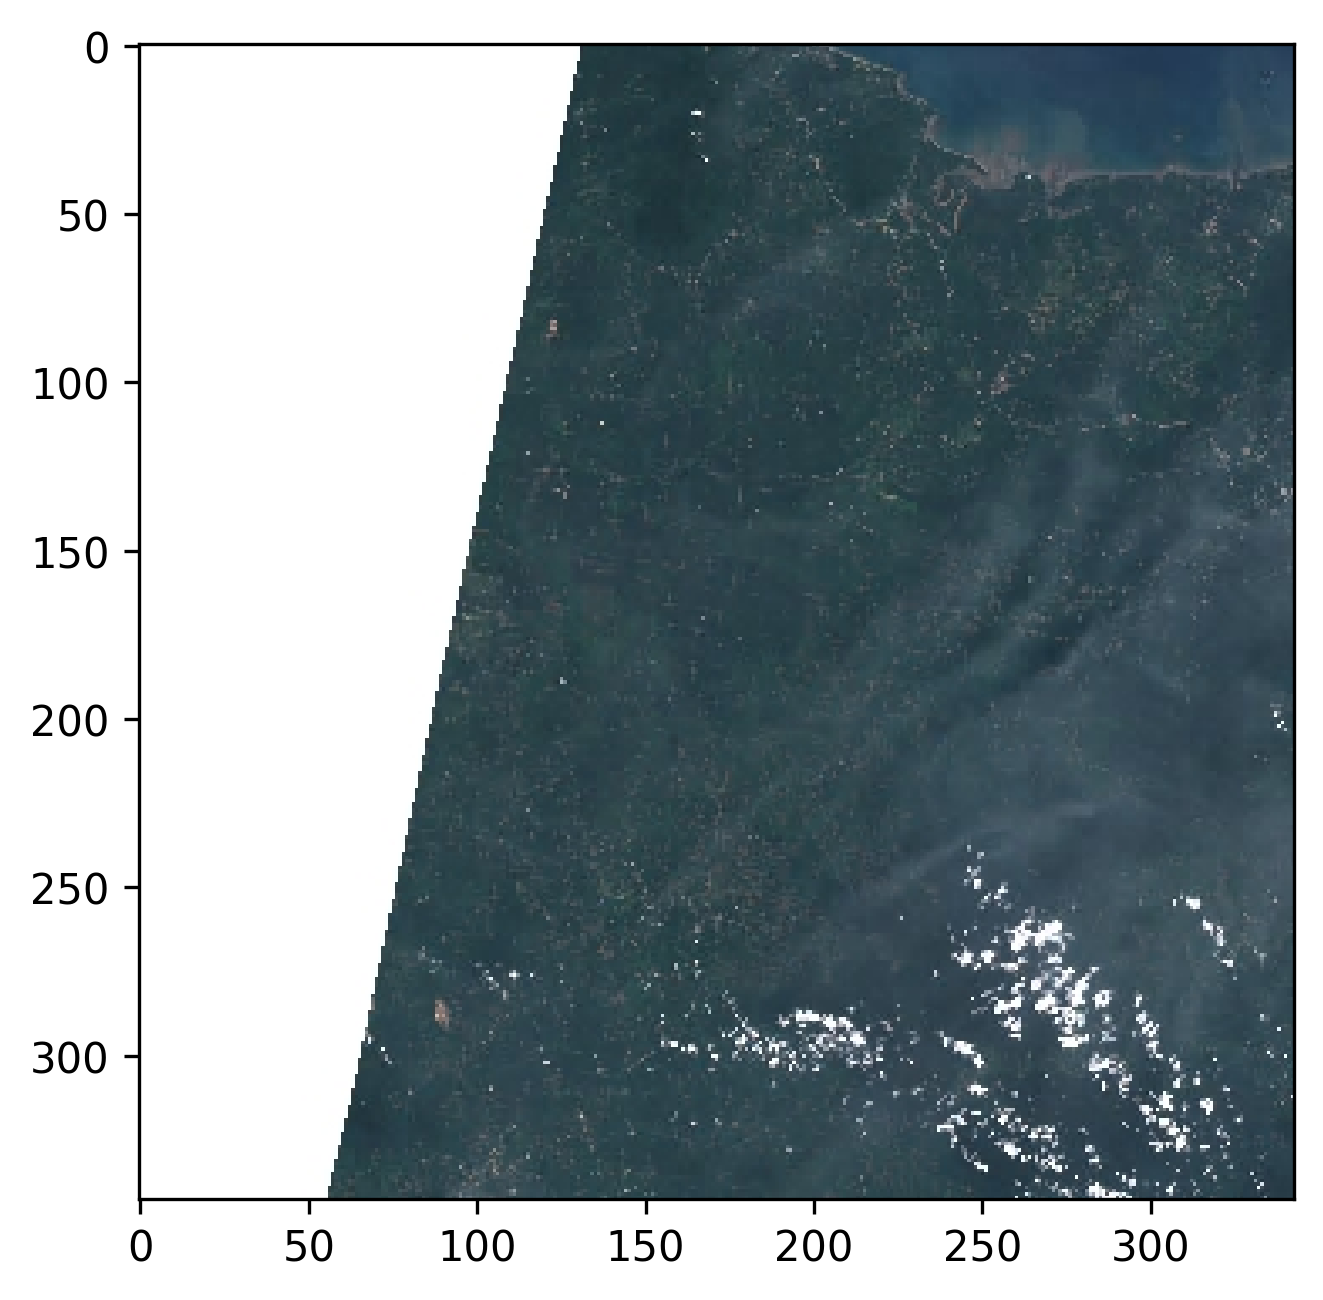

In [ ]:
# 最も雲の量が少ないシーンを選択し、サムネイル画像も取得する関数を定義します。
def sel_items(scene_items, product_id):
 item = [x.assets for x in scene_items\
         if x.properties['sentinel:product_id'] == product_id]
 thumbUrl = [x.assets['thumbnail'].href for x in scene_items\
             if x.properties['sentinel:product_id'] == product_id]
 return item, thumbUrl

selected_item, thumbUrl = sel_items(items, s2Gdf['sentinel:product_id'][0])

thumbImg = Image.open(BytesIO(requests.get(thumbUrl[0]).content))
plt.figure(figsize=(5, 5))
plt.imshow(thumbImg);

In [ ]:
allthumbUrl = []
for item in items:
  allthumbUrl.append(item.assets['thumbnail'].href)

len(allthumbUrl)

4

In [ ]:
def getPreview(thumbList, r_num, c_num, figsize_x=12, figsize_y=12):
  """
  サムネイル画像を指定した引数に応じて行列状に表示
  r_num: 行数
  c_num: 列数
  """
  thumbs = thumbList
  f, ax_list = plt.subplots(r_num, c_num, figsize=(figsize_x,figsize_y))
  for row_num, ax_row in enumerate(ax_list):
    for col_num, ax in enumerate(ax_row):
      if len(thumbs) < r_num*c_num:
        len_shortage = r_num*c_num - len(thumbs) # 行列の不足分を算出
        count = row_num * c_num + col_num
        if count < len(thumbs):
          ax.label_outer() # サブプロットのタイトルと、軸のラベルが被らないようにします
          ax.imshow(io.imread(thumbs[row_num * c_num + col_num]))
          ax.set_title(thumbs[row_num * c_num + col_num][60:79])
        else:
          for i in range(len_shortage):
            blank = np.zeros([100,100,3],dtype=np.uint8)
            blank.fill(255)
            ax.label_outer()
            ax.imshow(blank)
      else:
        ax.label_outer()
        ax.imshow(io.imread(thumbs[row_num * c_num + col_num]))
        ax.set_title(thumbs[row_num * c_num + col_num][60:79])
  return plt.show();

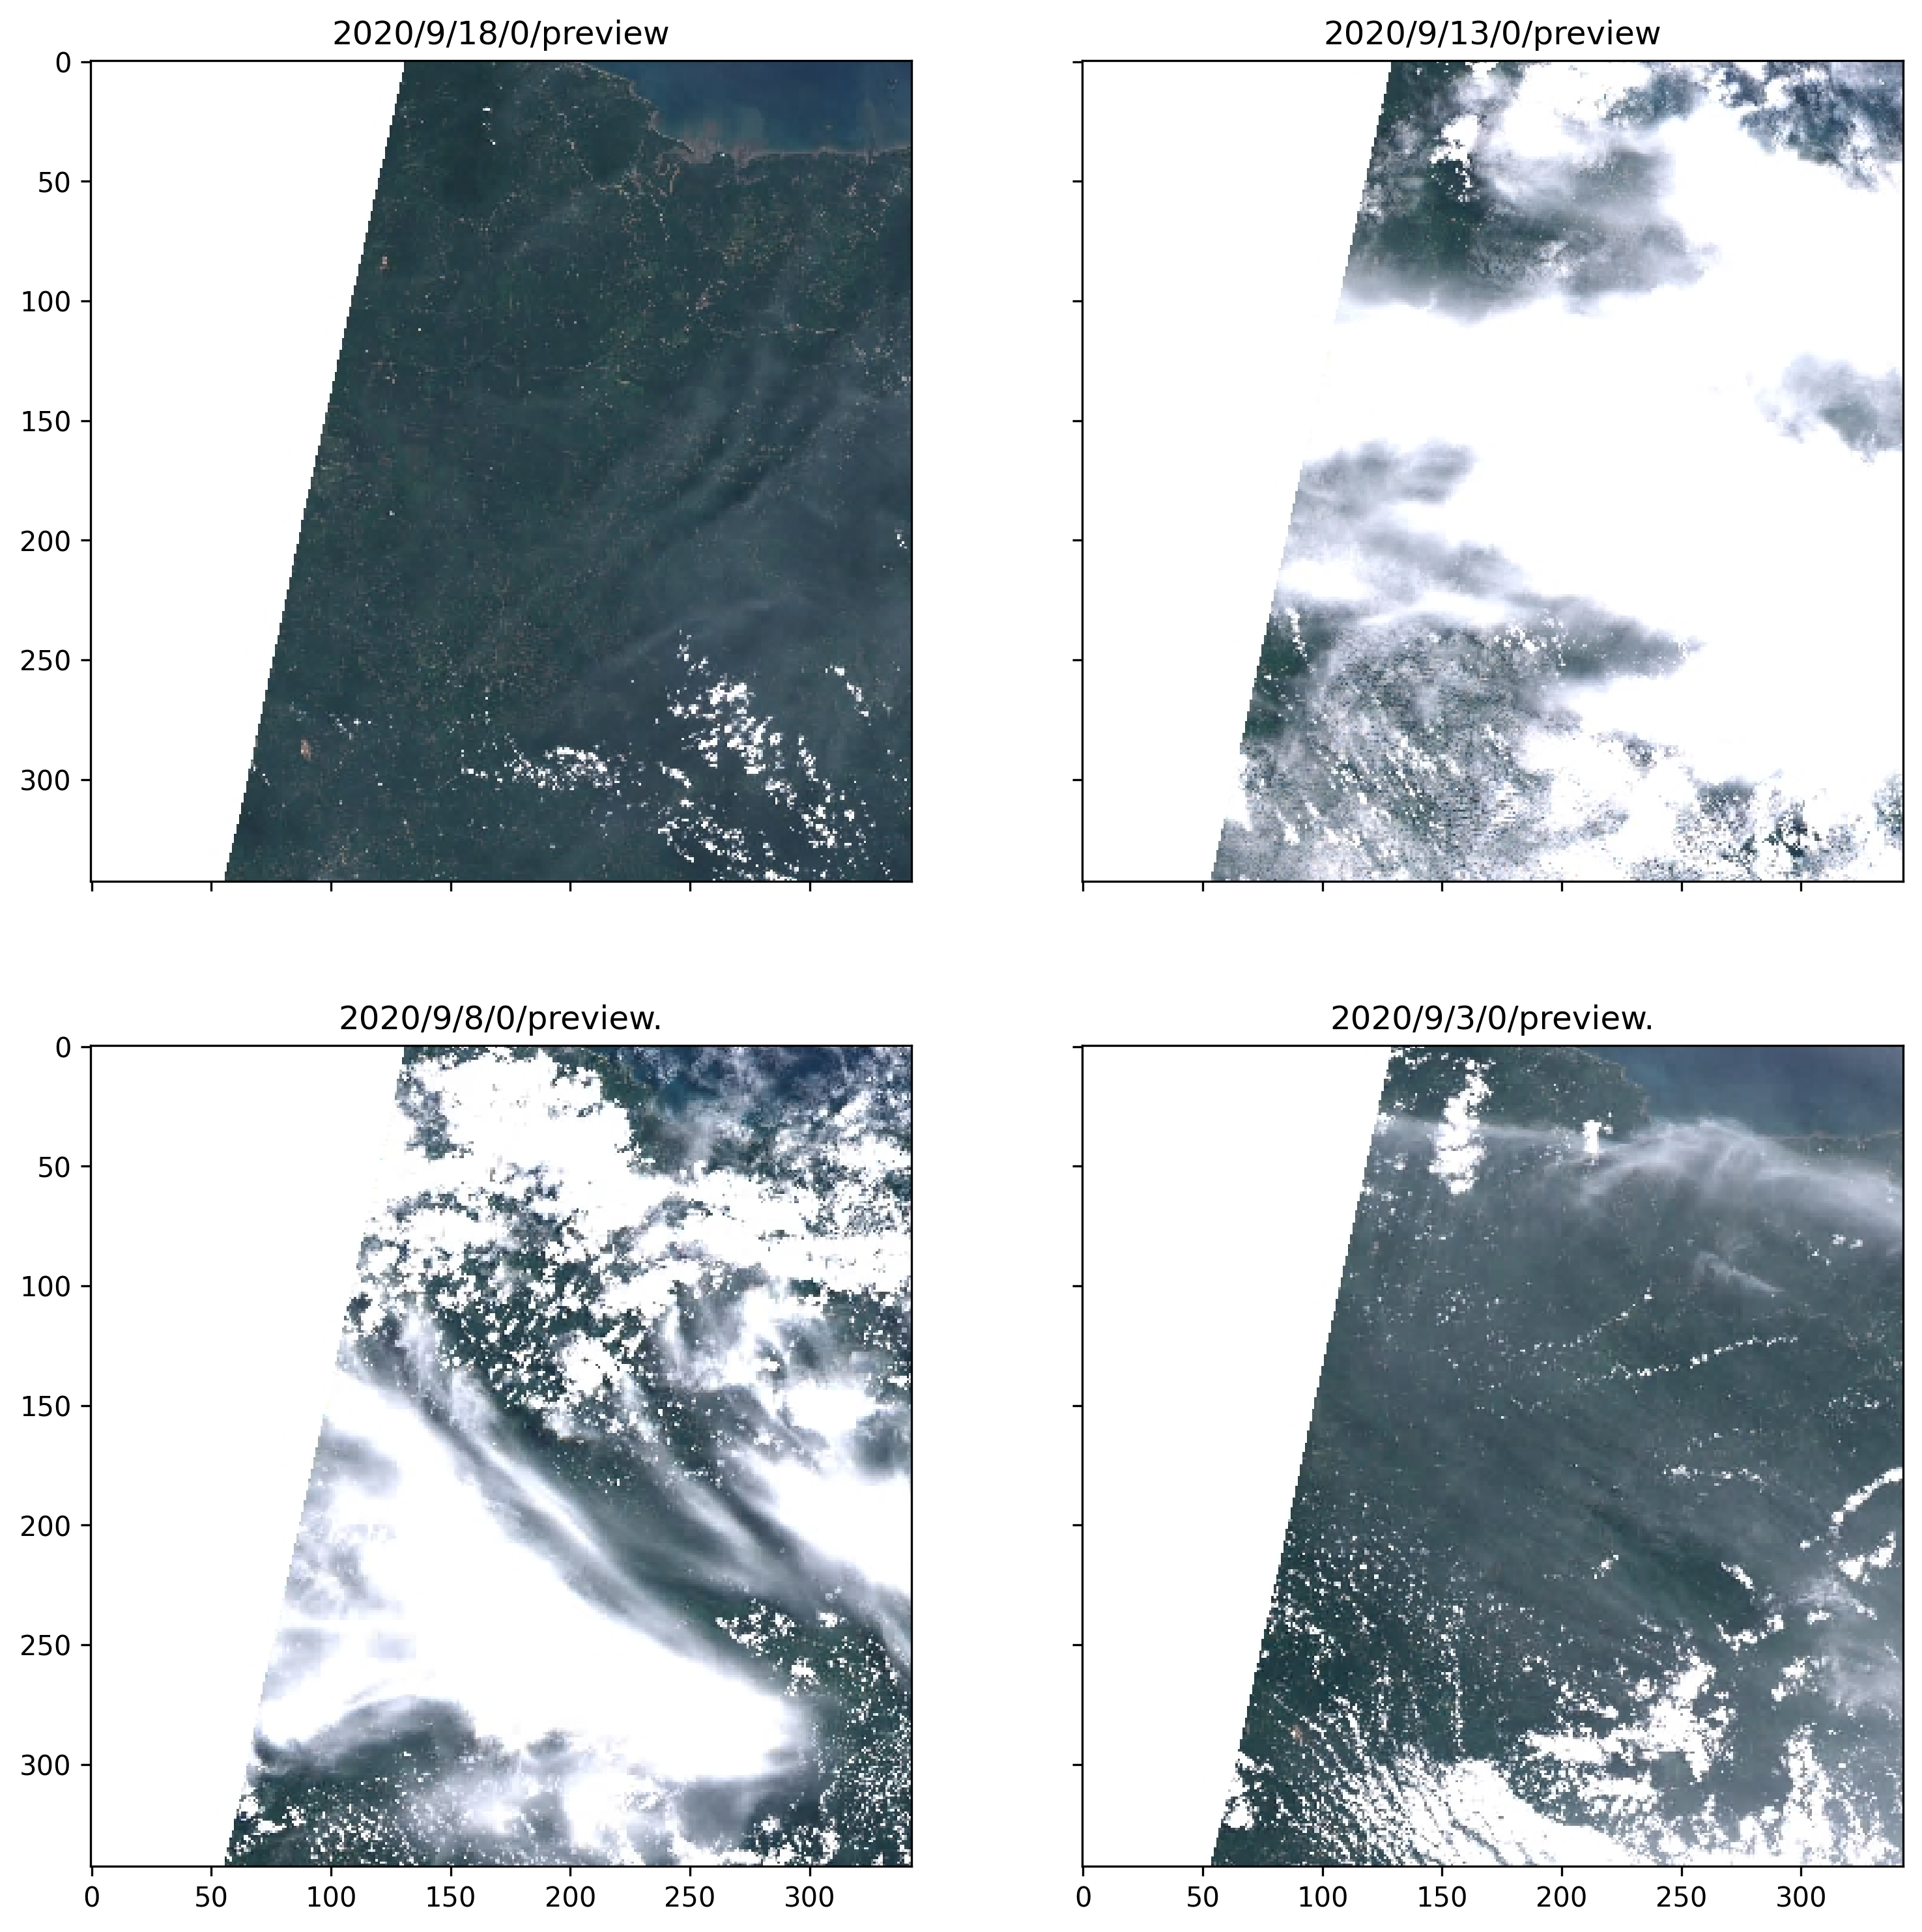

In [ ]:
getPreview(allthumbUrl,2,2)

In [ ]:
bandLists = ['B04', 'B03', 'B02']

file_url = []
for item in selected_item:
  for band in bandLists:
    file_url.append(item[band].href)

file_url

['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/49/N/CB/2020/9/S2B_49NCB_20200918_0_L2A/B04.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/49/N/CB/2020/9/S2B_49NCB_20200918_0_L2A/B03.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/49/N/CB/2020/9/S2B_49NCB_20200918_0_L2A/B02.tif']

In [ ]:
BBOX = box(109.945, 1.524, 109.973,1.548) # min lon, min lat, max lon, max lat
geo = gpd.GeoDataFrame(geometry=[BBOX], crs="EPSG:4326")
geo = geo.to_crs(crs='epsg:32649')

In [ ]:
def getFeatures(gdf):
  """rasterioで読み取れる形のデータに変換するための関数"""
  return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [ ]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[385754.61600482115, 168475.42259676204], [385755.8909065056, 171128.5913045548], [382640.80454243, 171130.12042767231], [382639.49486238265, 168476.9280349871], [385754.61600482115, 168475.42259676204]]]}]


In [ ]:
# 画像の読み込み
b2 = rio.open(file_url[2])
b3 = rio.open(file_url[1])
b4 = rio.open(file_url[0])

# 出力ファイル名
RGB_path = os.path.join(os.getcwd(),'sentinel-2_l2a-cogs.tif') # オリジナル画像

# GeoTIFFの作成
RGB_colar = rio.open(RGB_path,'w',driver='Gtiff', #driverにGtiff(GeoTIFF)
    width=b4.width, height=b4.height, #画像の高さや幅を指定。B04のバンドと同じ大きさにしています
    count=3, #3つのバンドを利用 (B02, B03, B04)
    crs=b4.crs, #crsもB04と同様。epsg:32649
    transform=b4.transform, #データに対する変換も同様のもの
    dtype=rio.uint16 #データ型を指定
    )
# 各々のバンド情報をRGB_colorに書き込み
RGB_colar.write(b2.read(1),3) #青
RGB_colar.write(b3.read(1),2) #緑
RGB_colar.write(b4.read(1),1) #赤
RGB_colar.close()

# 画像の切り取り処理

with rio.open(RGB_path) as src:
  out_image, out_transform = rio.mask.mask(src, coords, crop=True) # mask処理の実行
  out_meta = src.meta #　作成する画像の情報はもともとの画像と同様のものにします

# メタ情報の更新
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# 画像の書き出し
with rio.open(RGB_path, "w", **out_meta) as dest:
  dest.write(out_image)

# 画像表示のため8bit形式で書き出し。
scale = '-scale 0 255 0 25'
options_list = ['-ot Byte','-of Gtiff',scale]
options_string = " ".join(options_list)
# 切り出し画像の作成
gdal.Translate(os.path.join(os.getcwd(),'sentinel-2_l2a-cogs_Masked'+'.tif'),os.path.join(os.getcwd(),'sentinel-2_l2a-cogs.tif'),options = options_string)

print("done")

done


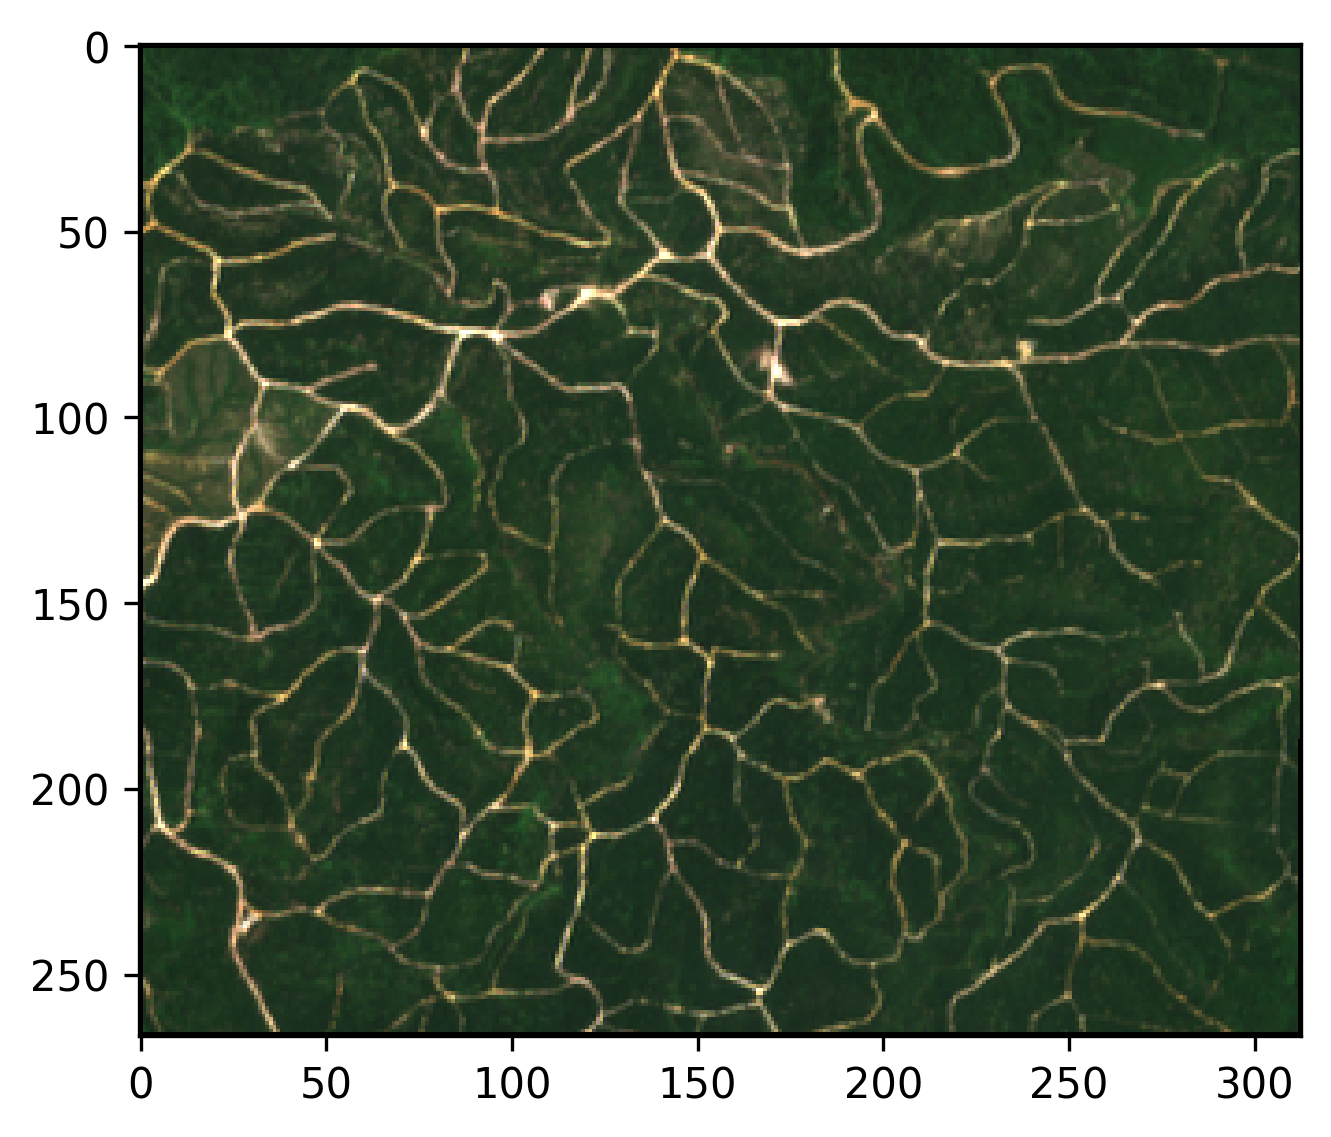

In [ ]:
plt.figure(figsize=(5, 5))
trueClipped = rio.open('/content/sentinel-2_l2a-cogs_Masked.tif')
show(trueClipped.read([1,2,3]));

> 網の目に広がる道路が確認できました。  
NDVIを求めていきましょう。赤の波長帯データ（バンド4）と近赤外線のデータ（バンド8）から求めます。NDVIを作成するために、`np.divide(A, B, out=np.zeros_like(A), where=(B!=0))` は、第1引数（A）を第2引数（B）で割る計算を行います。  
out=... は計算結果として出力される配列の形式を指定するための引数で、np.zeros_like(A) と書くことで「Aと同じ形をした配列」という指定ができます。また、最後の where=(B!=0) は、ゼロで割り算しないようにするための指定です。Bが0だった場合は、割り算は行わず、0という計算結果が返ります。

In [ ]:
bandLists = ['B04', 'B08']

file_url = []
for item in selected_item:
  for band in bandLists:
    file_url.append(item[band].href)

file_url

['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/49/N/CB/2020/9/S2B_49NCB_20200918_0_L2A/B04.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/49/N/CB/2020/9/S2B_49NCB_20200918_0_L2A/B08.tif']

In [ ]:
# 画像の読み込み
b4 = rio.open(file_url[0])
red = b4.read()
b8 = rio.open(file_url[1])
nir = b8.read()
ndvi = np.where(((red != 0) & (nir != 0)),(nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float)), 0) # NDVI算出


out_meta = b4.meta
out_meta.update(driver='GTiff')
out_meta.update(dtype=rasterio.float32)

# 出力ファイル名
NDVI_path = os.path.join(os.getcwd(),'kalimantan_ndvi.tif')

with rio.open(NDVI_path, 'w', **out_meta) as dst:
  dst.write(ndvi.astype(rasterio.float32))

print("---masking---")


# 画像の切り取り処理
with rio.open(NDVI_path) as src:
  out_image, out_transform = rio.mask.mask(src, coords, crop=True) #mask処理の実行
  out_meta = src.meta #作成する画像の情報はもともとの画像と同様のものにします

# メタ情報の更新
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
# 画像の書き出し
with rio.open(NDVI_path, "w", **out_meta) as dest:
  dest.write(out_image)

print("Done")

---masking---
Done


> 保存した画像を、植生指標データの1-255の値に変換し、その値をグレースケールの濃度と見なして画像変換して表示すると、次のようになります。

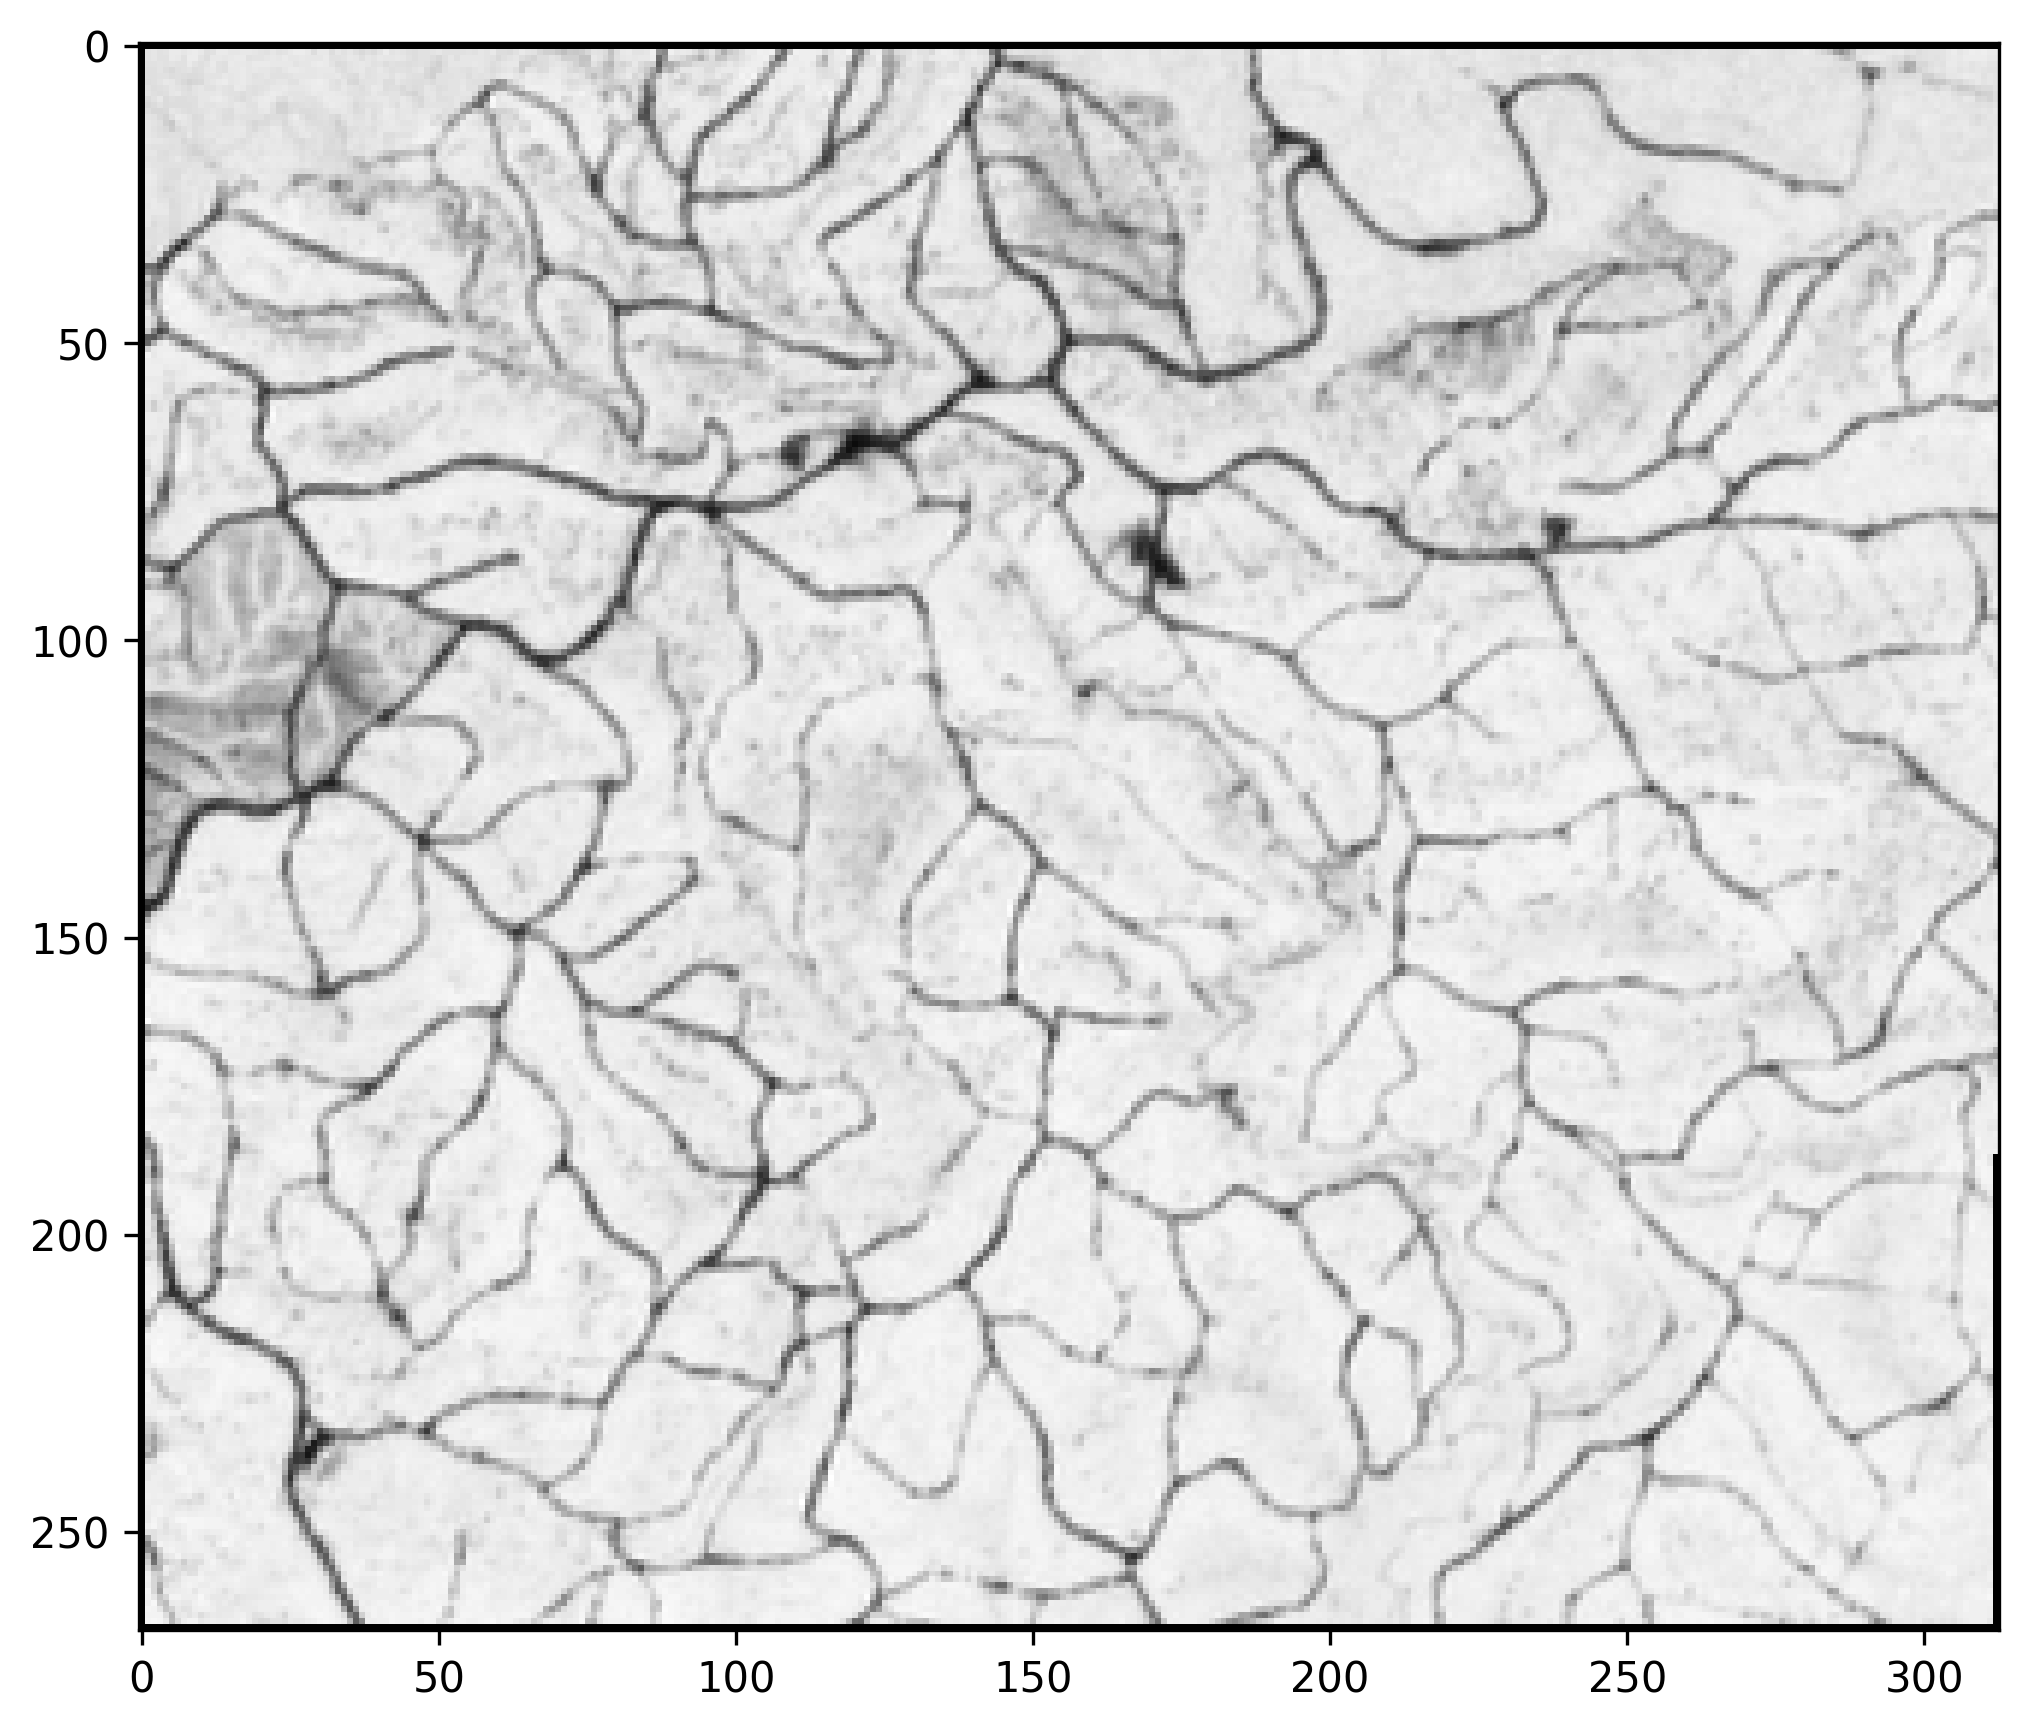

In [ ]:
# 切り抜いた画像を読み込む
ca_image_nvdi = rio.open('/content/kalimantan_ndvi.tif')

# -1〜1までのNDVI値を1〜255までの整数値に変換する
# https://gis.stackexchange.com/questions/28559/normalize-raster-values-to-0-255/28590
nvdi_image_data = (((ca_image_nvdi.read(1)) + 1.0) * 255/2).astype(np.uint8)

# グレースケール画像として表示する（明るいところほど植物の植生が良い）
plt.figure(figsize=(8, 8))
plt.imshow(nvdi_image_data, cmap="gray");

> 白い部分が、植生指標の大きいところ（植物が育成しているところ）、黒い部分が小さいところ（植物の少ないところ）です。黒い直線が東西南北に伸びています。これが、農園内に作られた道路です。  
次にフィルタを使って画像のノイズを除去します。フィルターはブラーフィルタなどを使っても良いのですが、今回はエッジを残しつつ平滑化を行うバイラテラルフィルタを使用しています。バイラテラルフィルタの使い方は以下のとおりです。  
`出力画像 = cv2.bilateralFilter(入力画像, ぼかす領域, 色空間の標準偏差, 距離の標準偏差)`  
「ぼかす領域、色空間の標準偏差、距離の標準偏差」はそれぞれ値が大きいと平滑化しやすくなる反面ぼけやすくなります。画像に応じて適切な値を微調整すると良いでしょう。ここでは、canny法を利用して道路を抽出する際のノイズを除去するために利用しています。

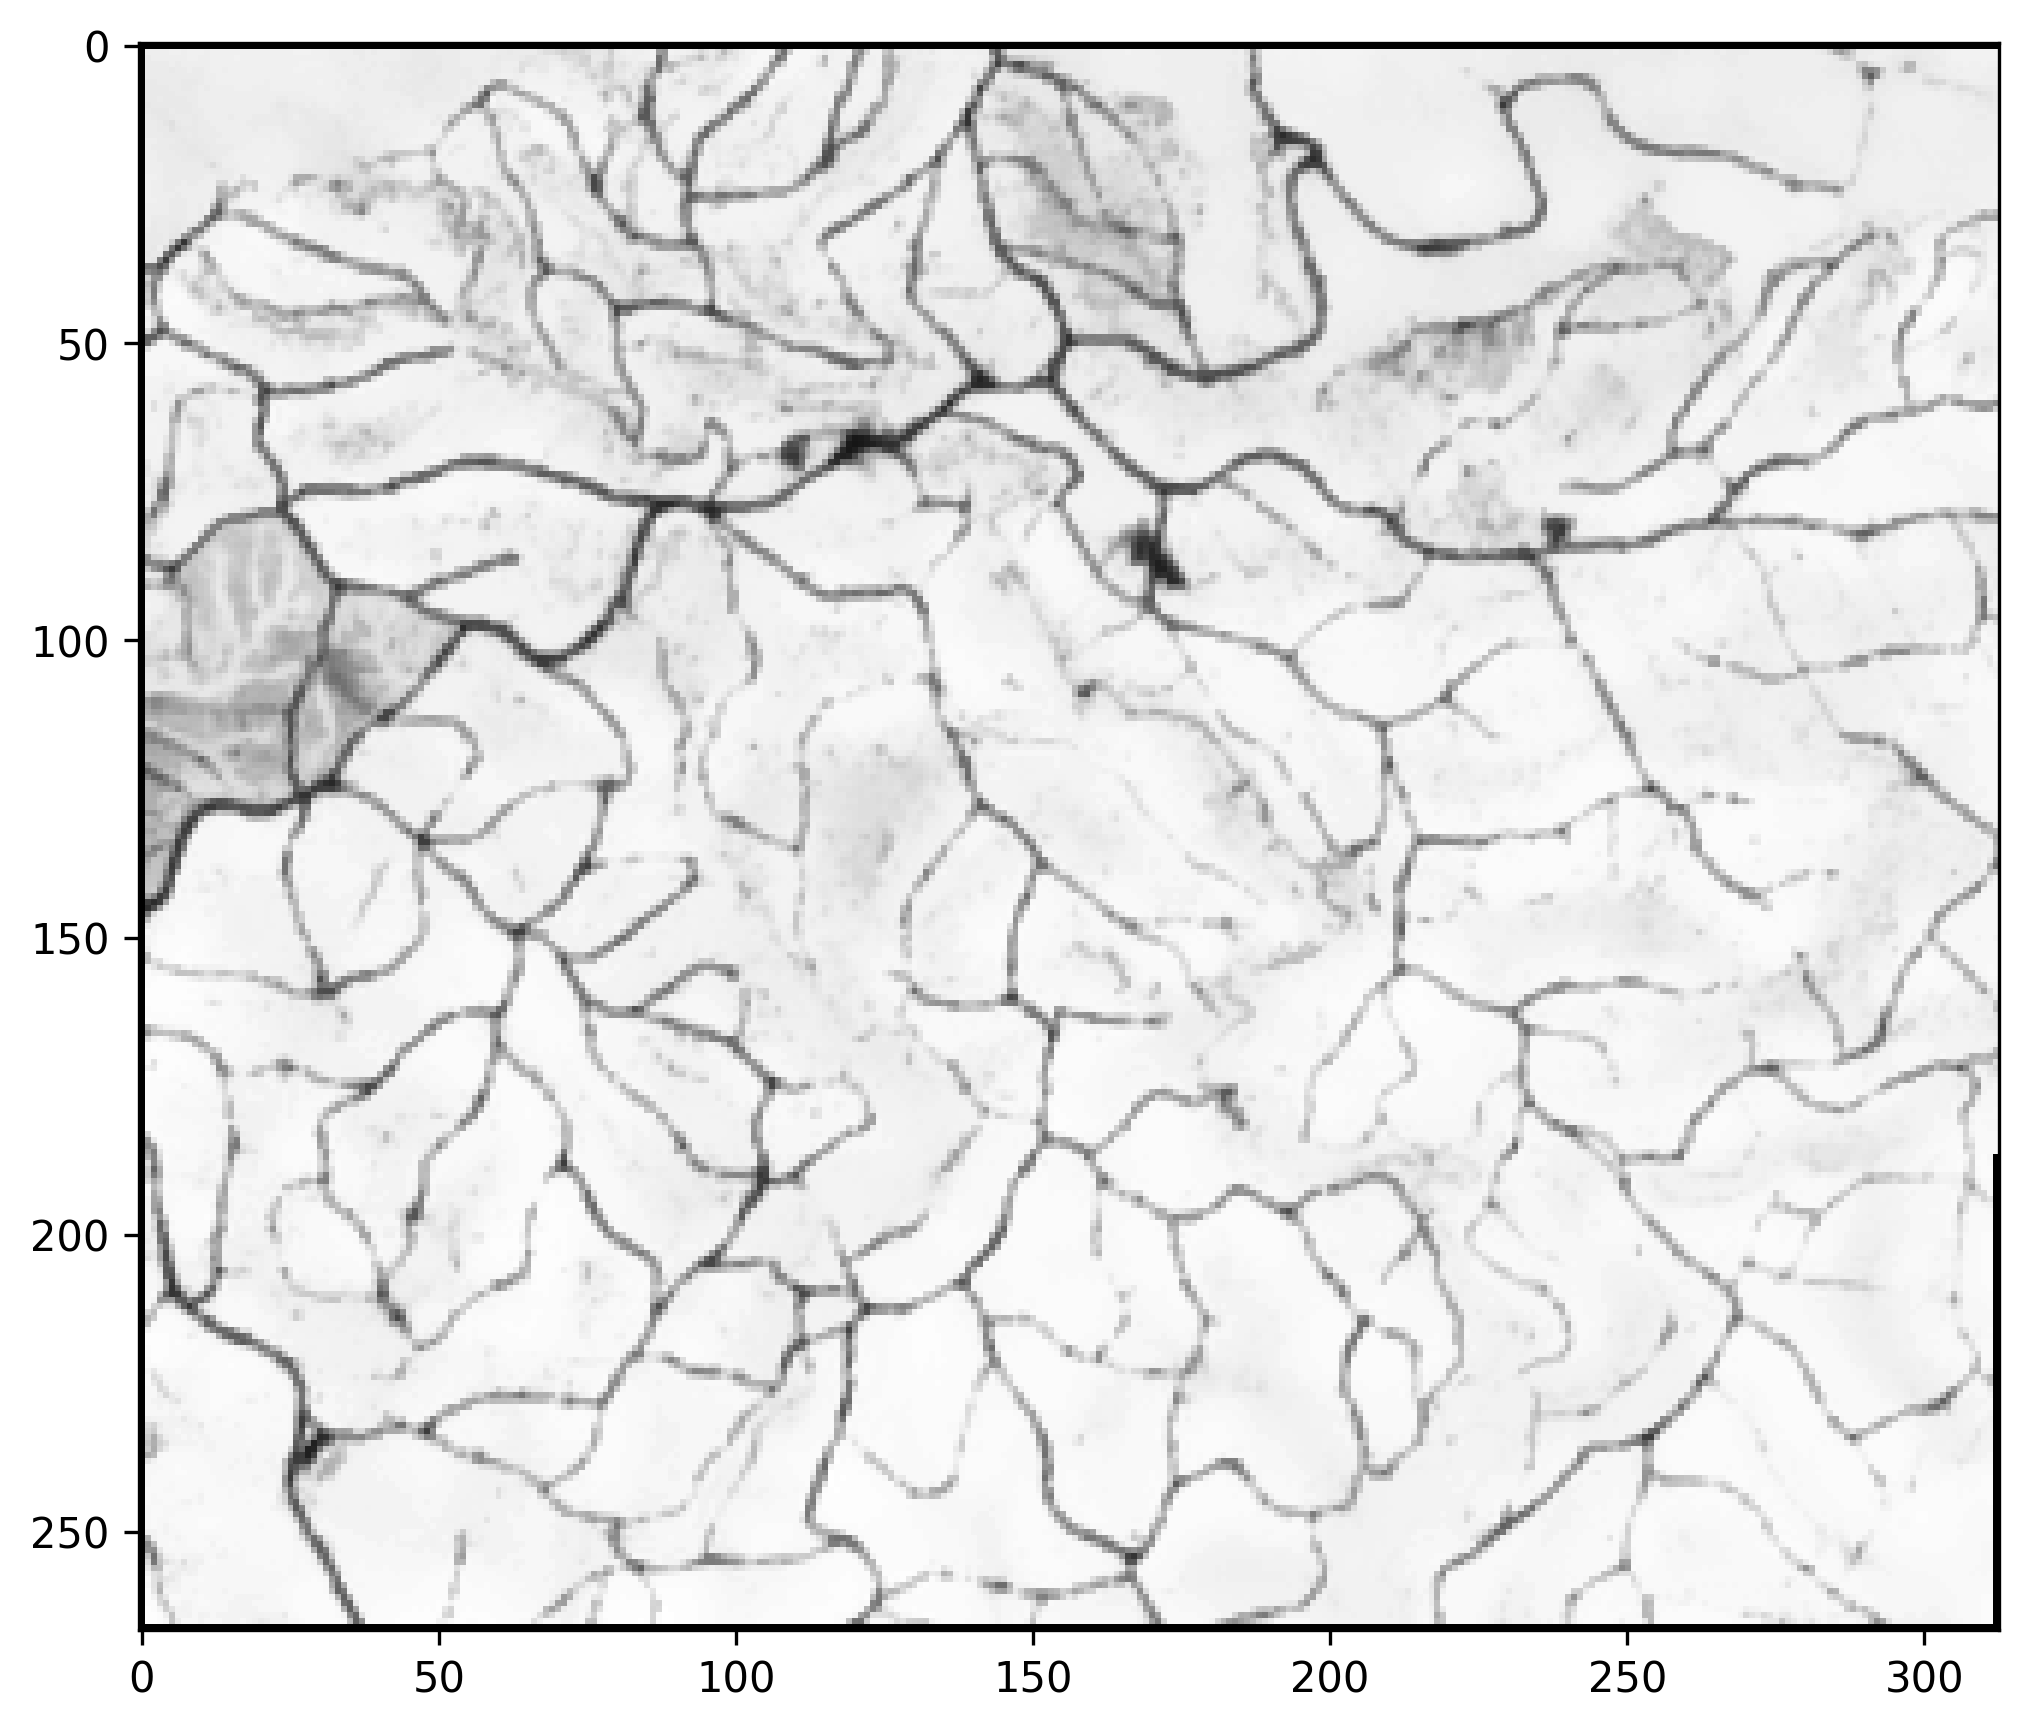

In [ ]:
# バイラテラルフィルタの適用
nvdi_image_data2 = cv2.bilateralFilter(nvdi_image_data, 10, 5, 10)

# フィルタを適用した画像を表示
plt.figure(figsize=(8,8))
plt.imshow(nvdi_image_data2, cmap="gray");

> それではここから道路の抽出を試みてみます。はじめはCanny法を使ったエッジの検出です。  
Canny法とは、エッジ検出の代表的なアルゴリズムの一つです。  
Canny法についての参考はこちら：  
https://imagingsolution.net/imaging/canny-edge-detector/

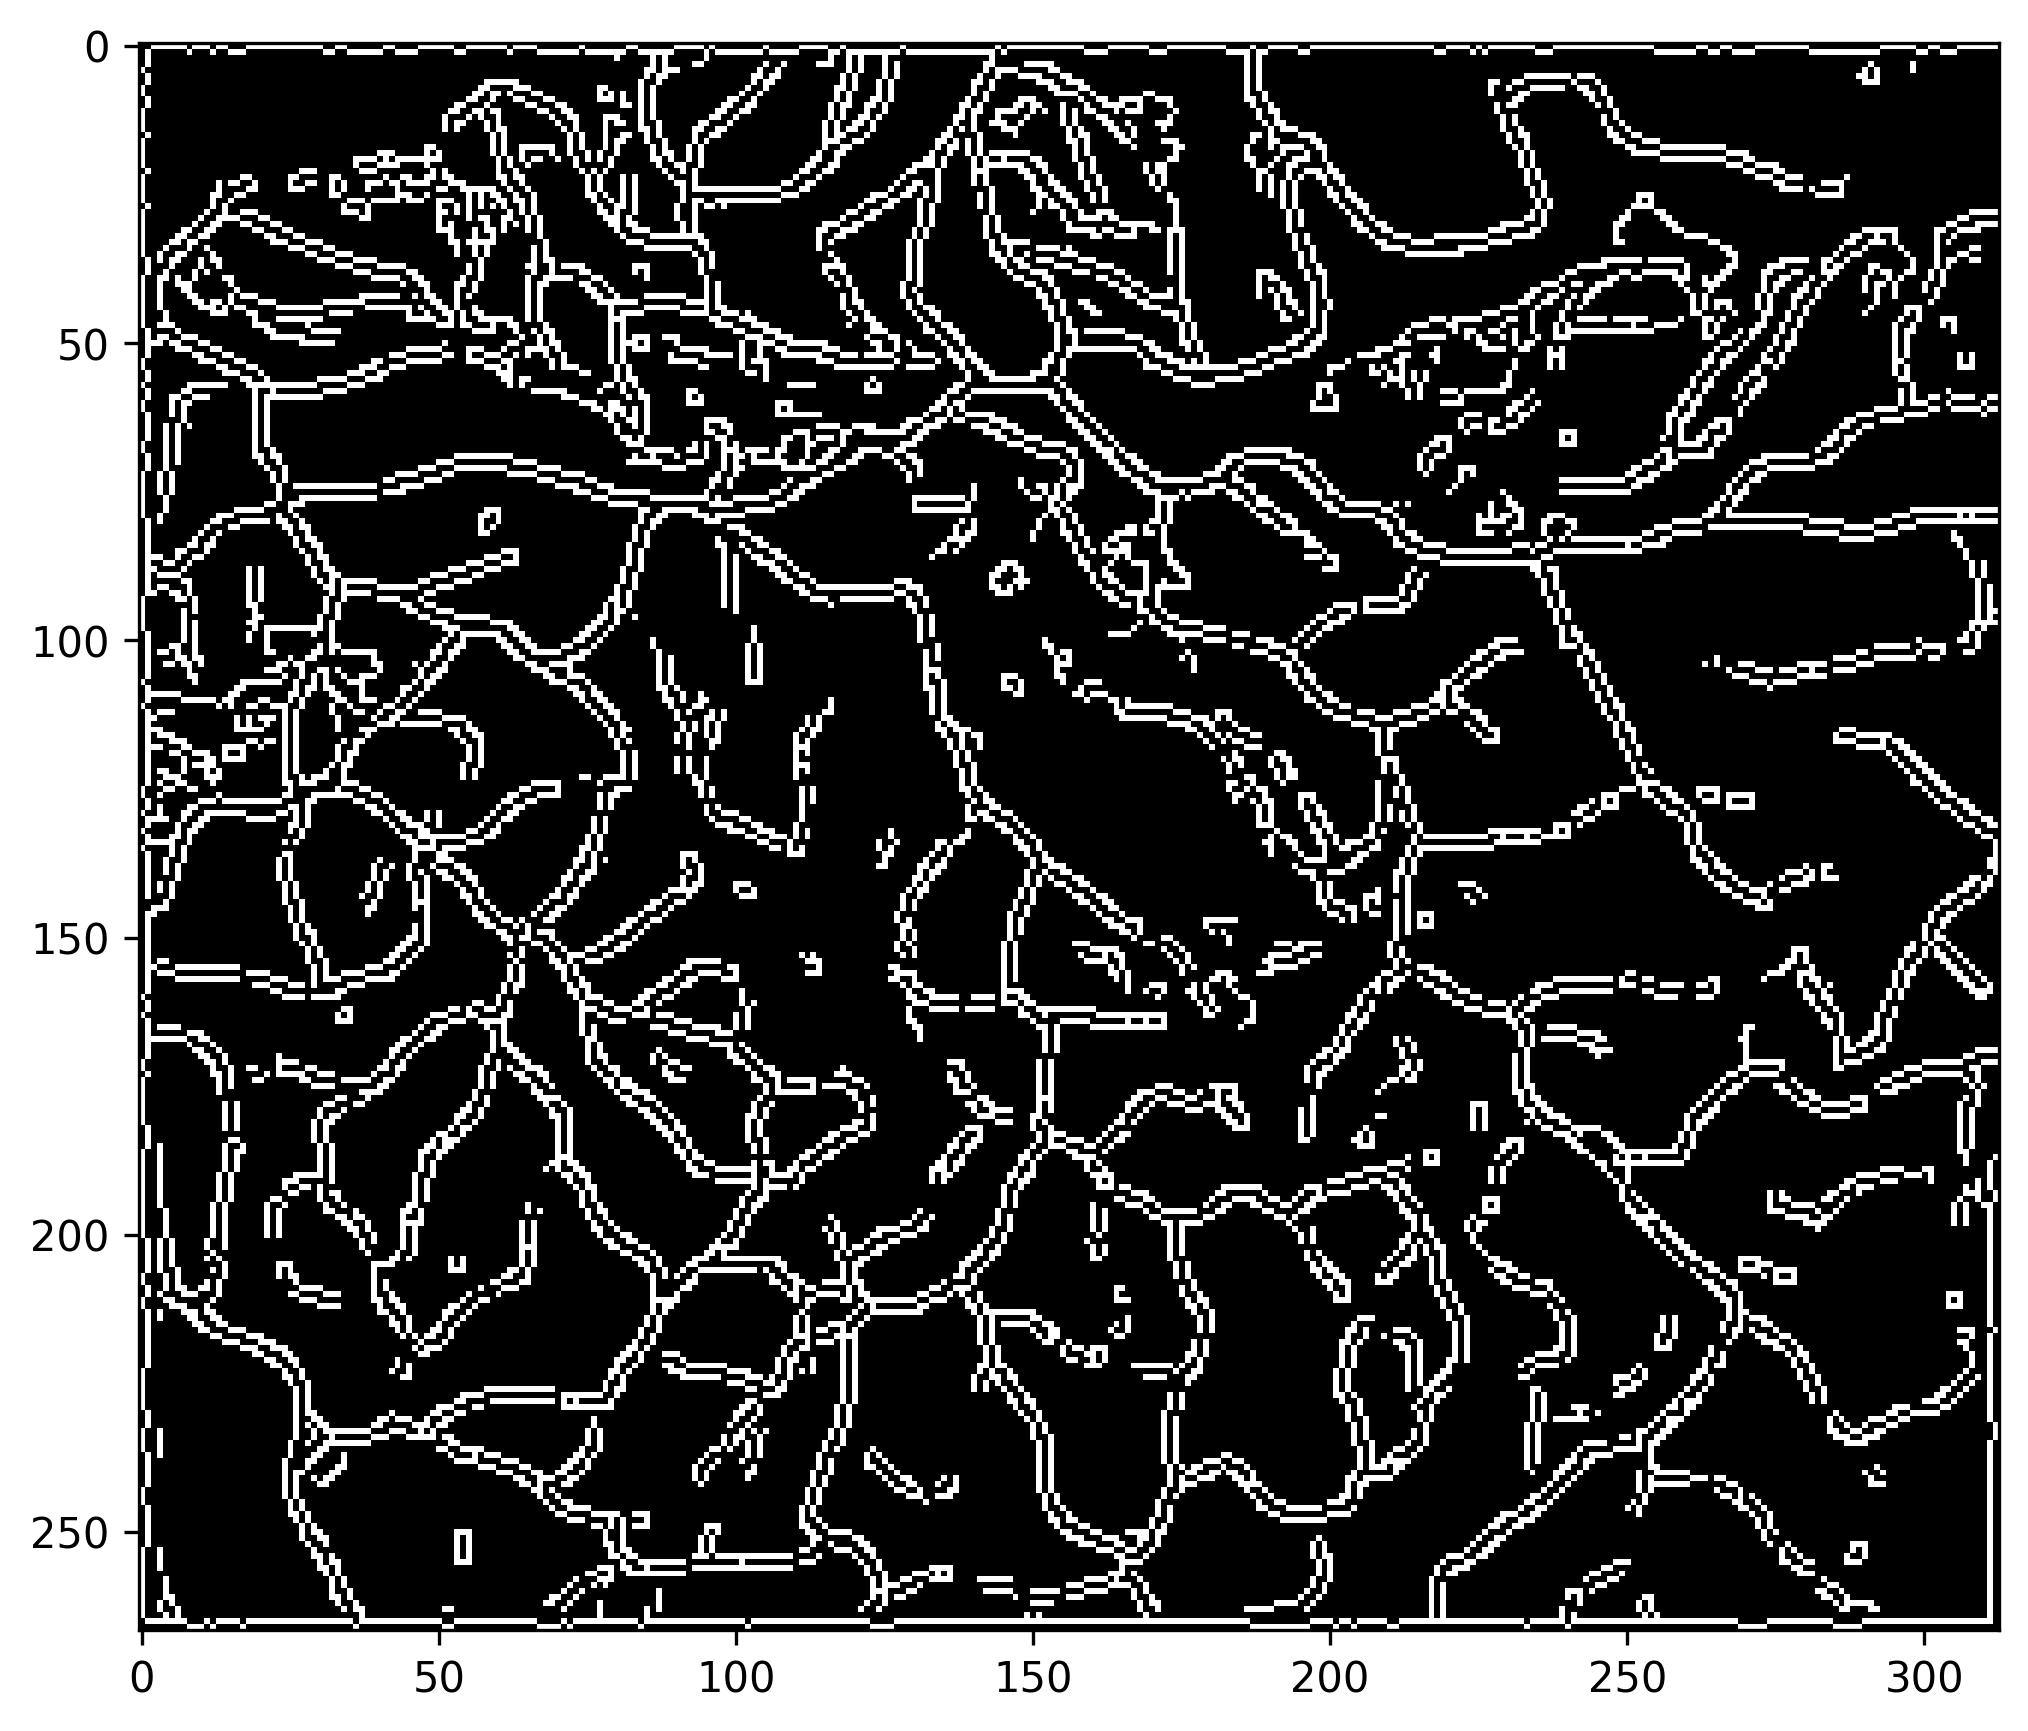

In [ ]:
# Canny法を使ったエッジを検出
nvdi_edged_canny = cv2.Canny(nvdi_image_data2, 50, 100)

# フィルタを適用した結果を表示
plt.figure(figsize=(8,8))
plt.imshow(nvdi_edged_canny, cmap="gray");

> 植生の違いからエッジを検出できました。かなり精度良く道路を抽出することができています。  
続いてラプラシアンフィルタを試して見ます。  
ラプラシアンフィルタとは二次微分を使ったエッジを抽出するフィルタです。線に強く反応するフィルタとして知られています。OpenCVではLaplacian()として実装されています。使い方は以下のとおりです。  
`出力画像 = cv2.Laplacian(入力画像, 色深度[, オプション])`  
色深度は画素を表現するビット数を指定します。基本的に入力画像の色深度と同じで良いでしょう。今回はグレースケールを入力画像とするため、色深度は8bit(cv2.CV_8U)を指定しています。また、オプションとして出力を強調するscaleに9を指定しています。値を大きくしすぎると余計な情報を取得し、検出にノイズが生じます。

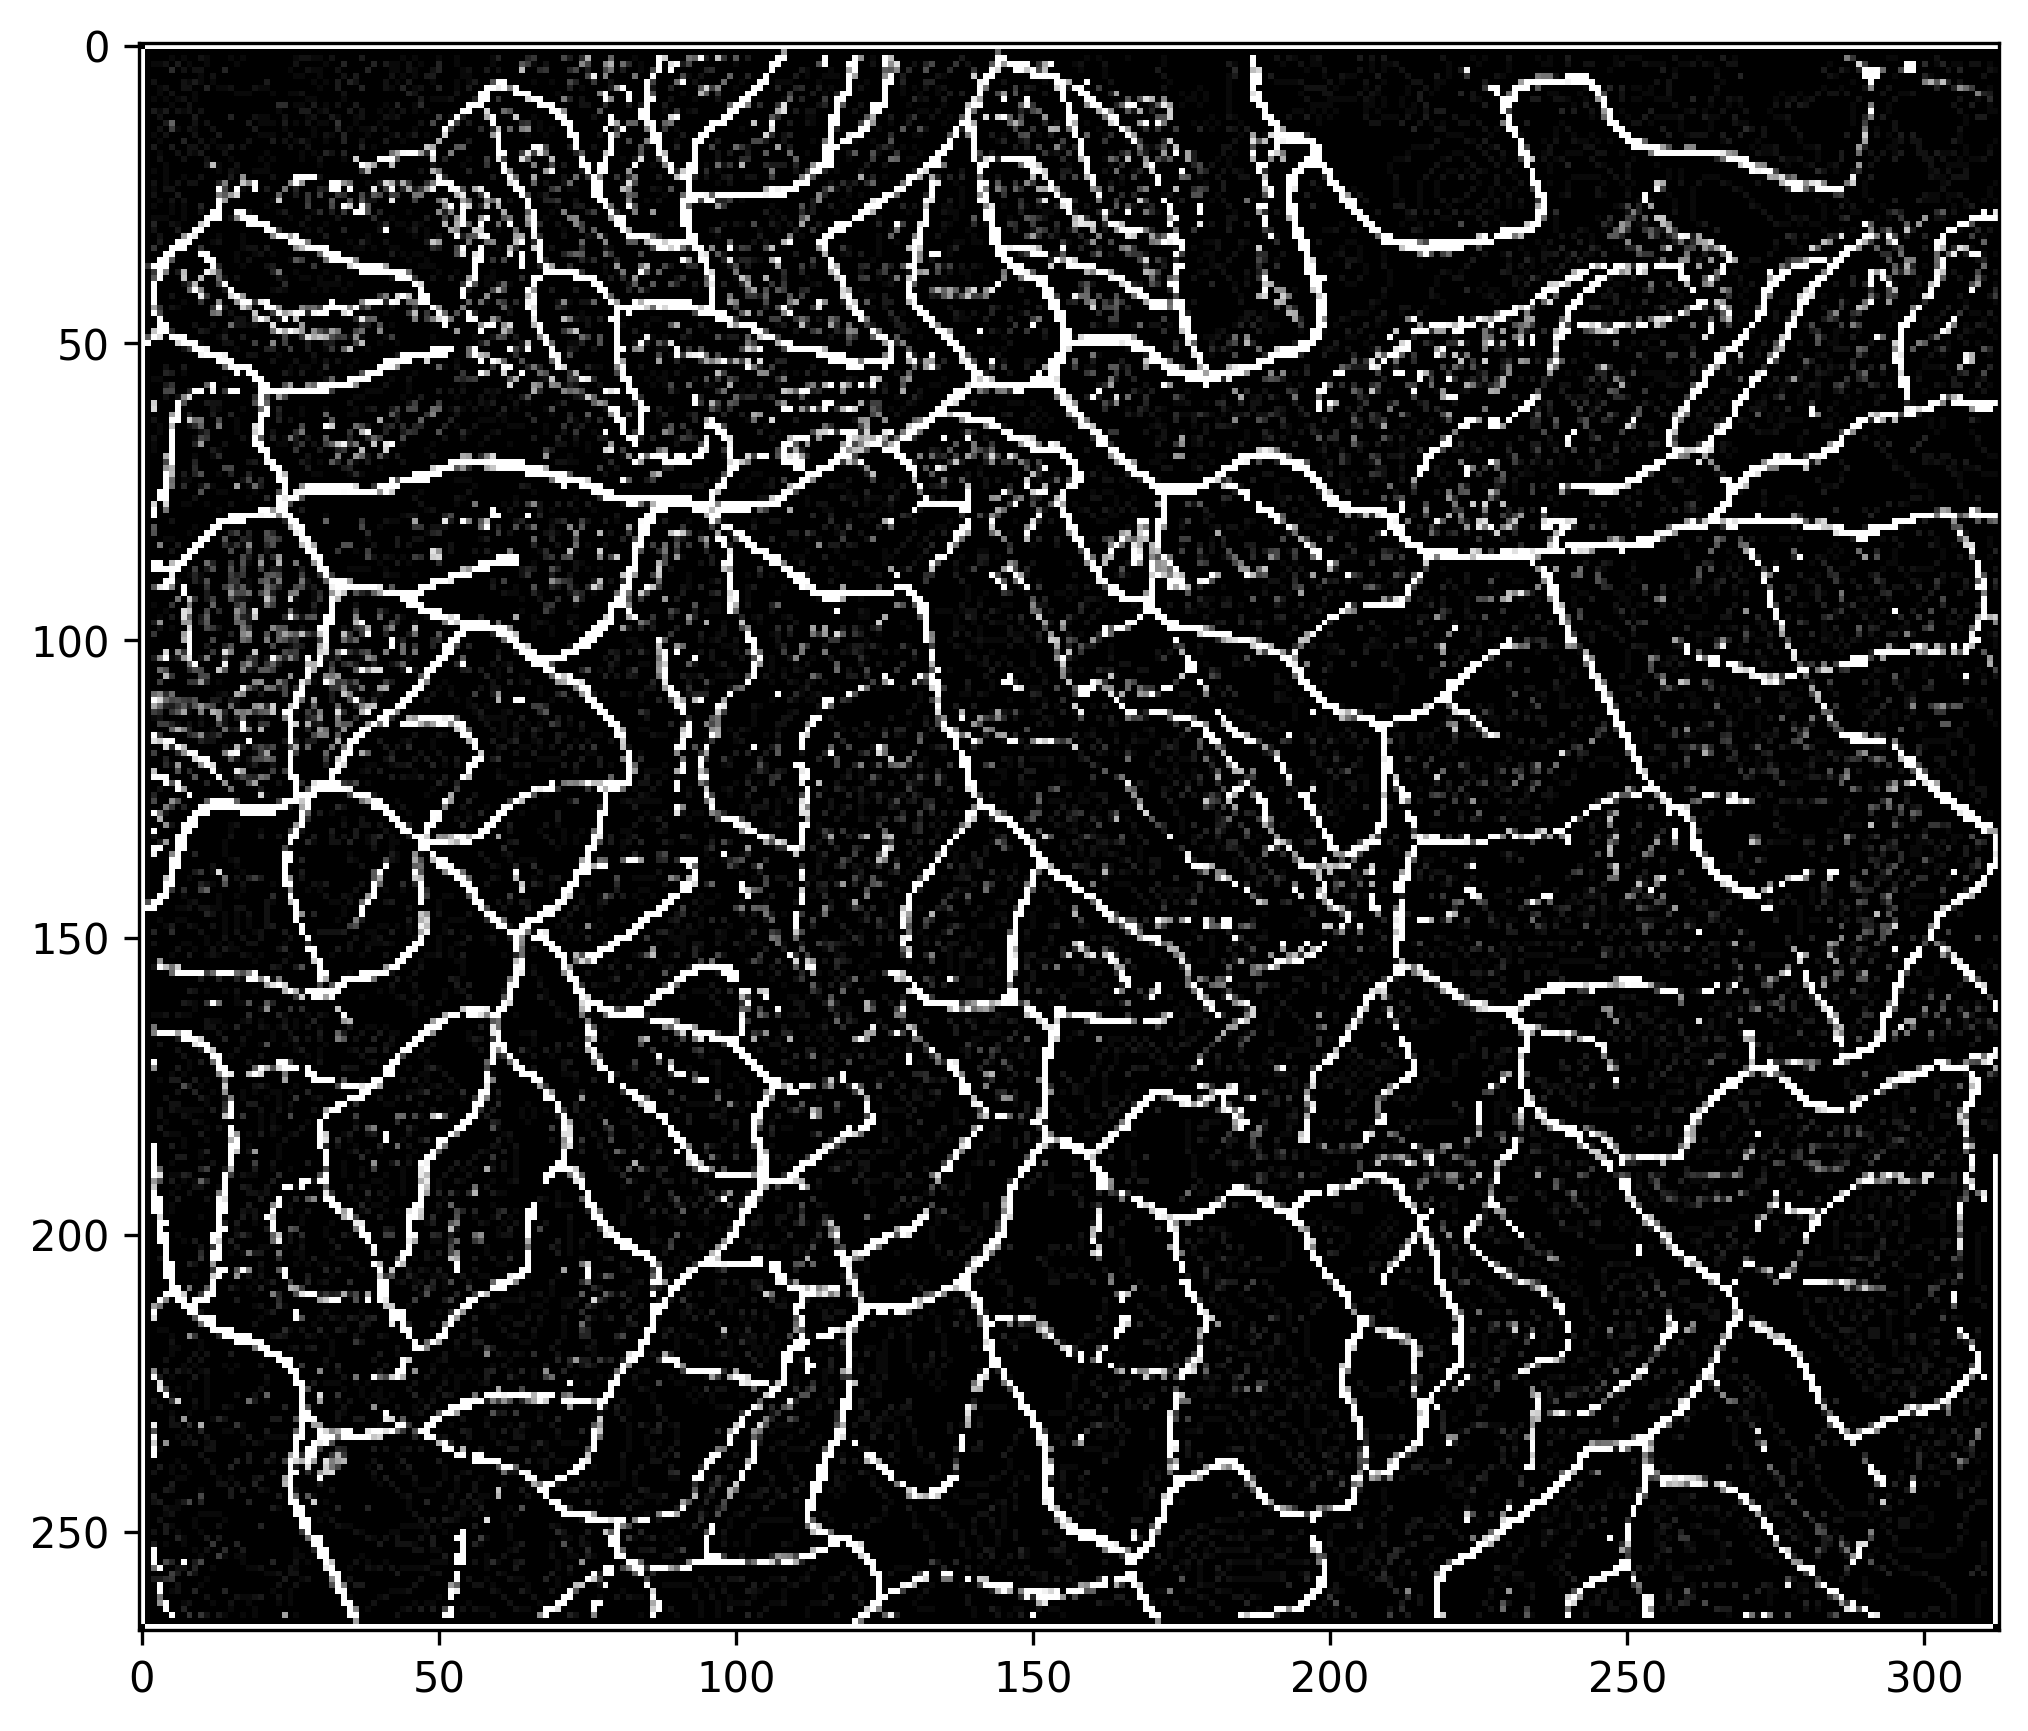

In [ ]:
# ラプラシアンフィルタの適用
nvdi_image_lap = cv2.Laplacian(nvdi_image_data2, cv2.CV_8U, scale=9)

# フィルタを適用した結果を表示
plt.figure(figsize=(8,8))
plt.imshow(nvdi_image_lap, cmap="gray");

> Canny法と比較すると、より繊細にエッジを検出できています。このままの結果でも道路を検出することができていますが、今回はさらにマスクを適用することで結果がどうなるのかについても考慮して見ます。  
道路は緑に覆われていない部分、つまりつまりNDVIの値が低い箇所であると考えられます。よってNDVIが低い部分をマスクとして抽出し、ラプラシアンフィルタで得られた結果と論理積演算することで、よりはっきり道路を抽出できないか、試してみましょう。  
まずはマスクを作成します。NDVIが低い箇所、すなわち値が低い部分を`inRange()`関数で取得します。

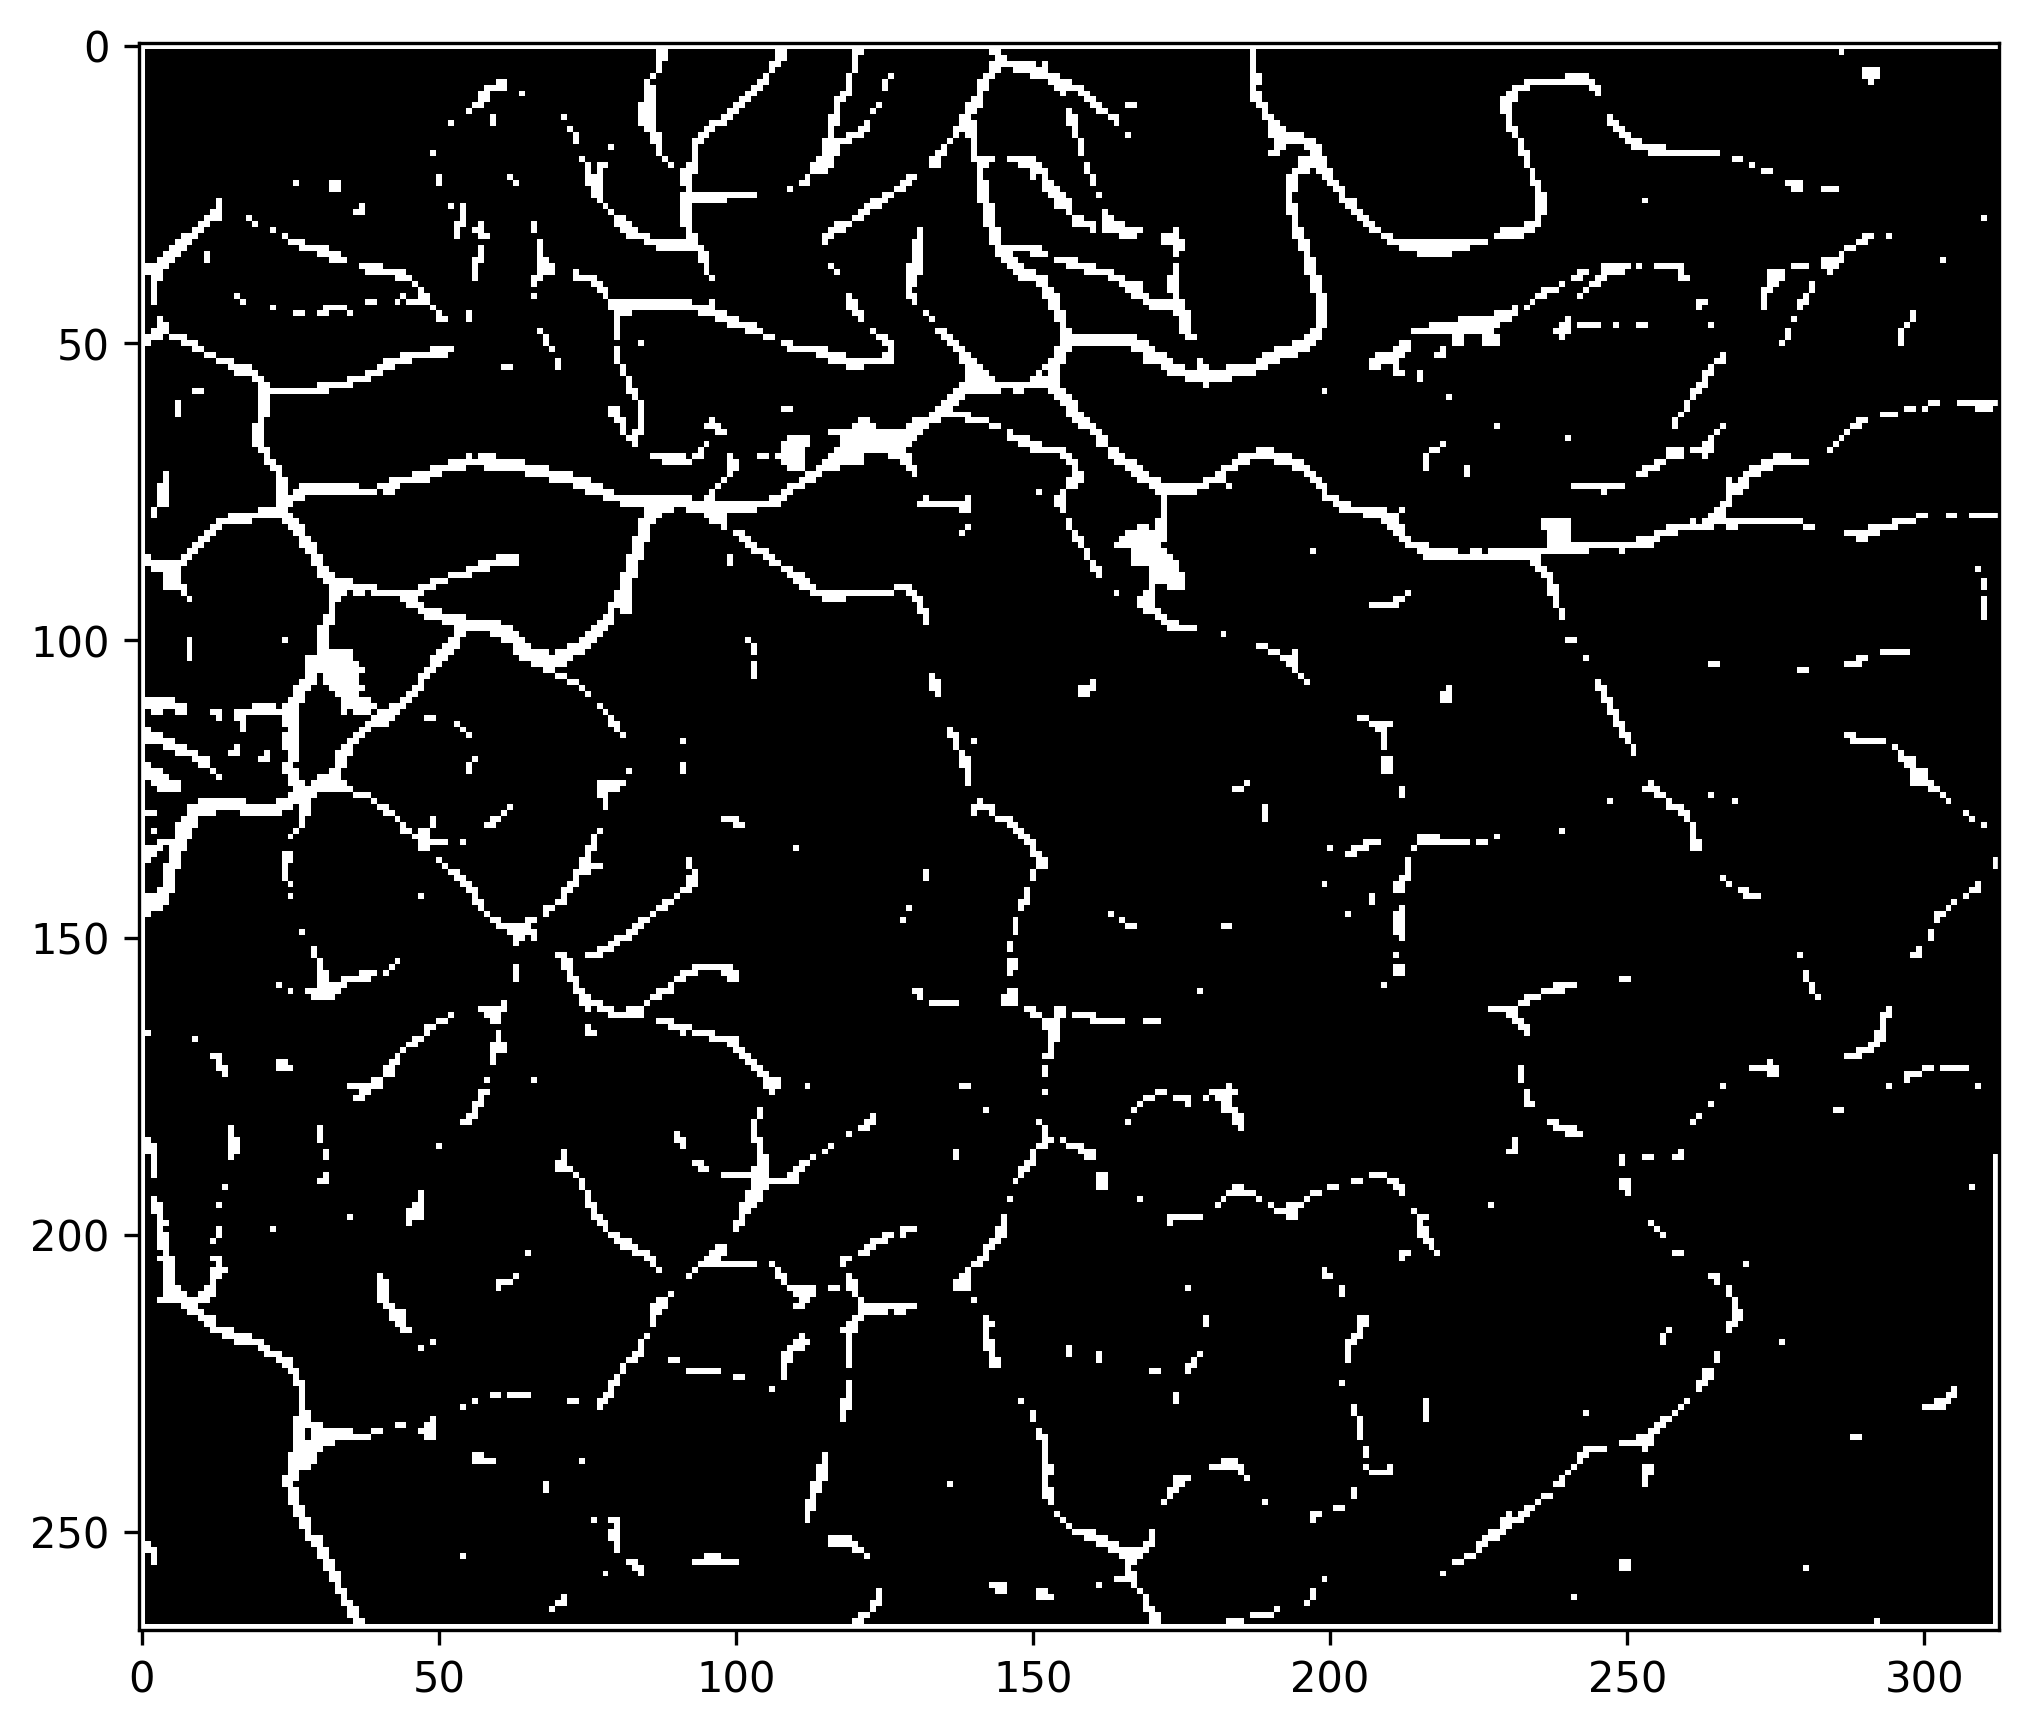

In [ ]:
# 色の強さが200以下の部分をマスクとして取得
nvdi_image_mask = cv2.inRange(nvdi_image_data2, 0, 200)

# マスクを表示
plt.figure(figsize=(8,8))
plt.imshow(nvdi_image_mask, cmap="gray");

> ラプラシアンフィルタの結果と論理積演算を行います。

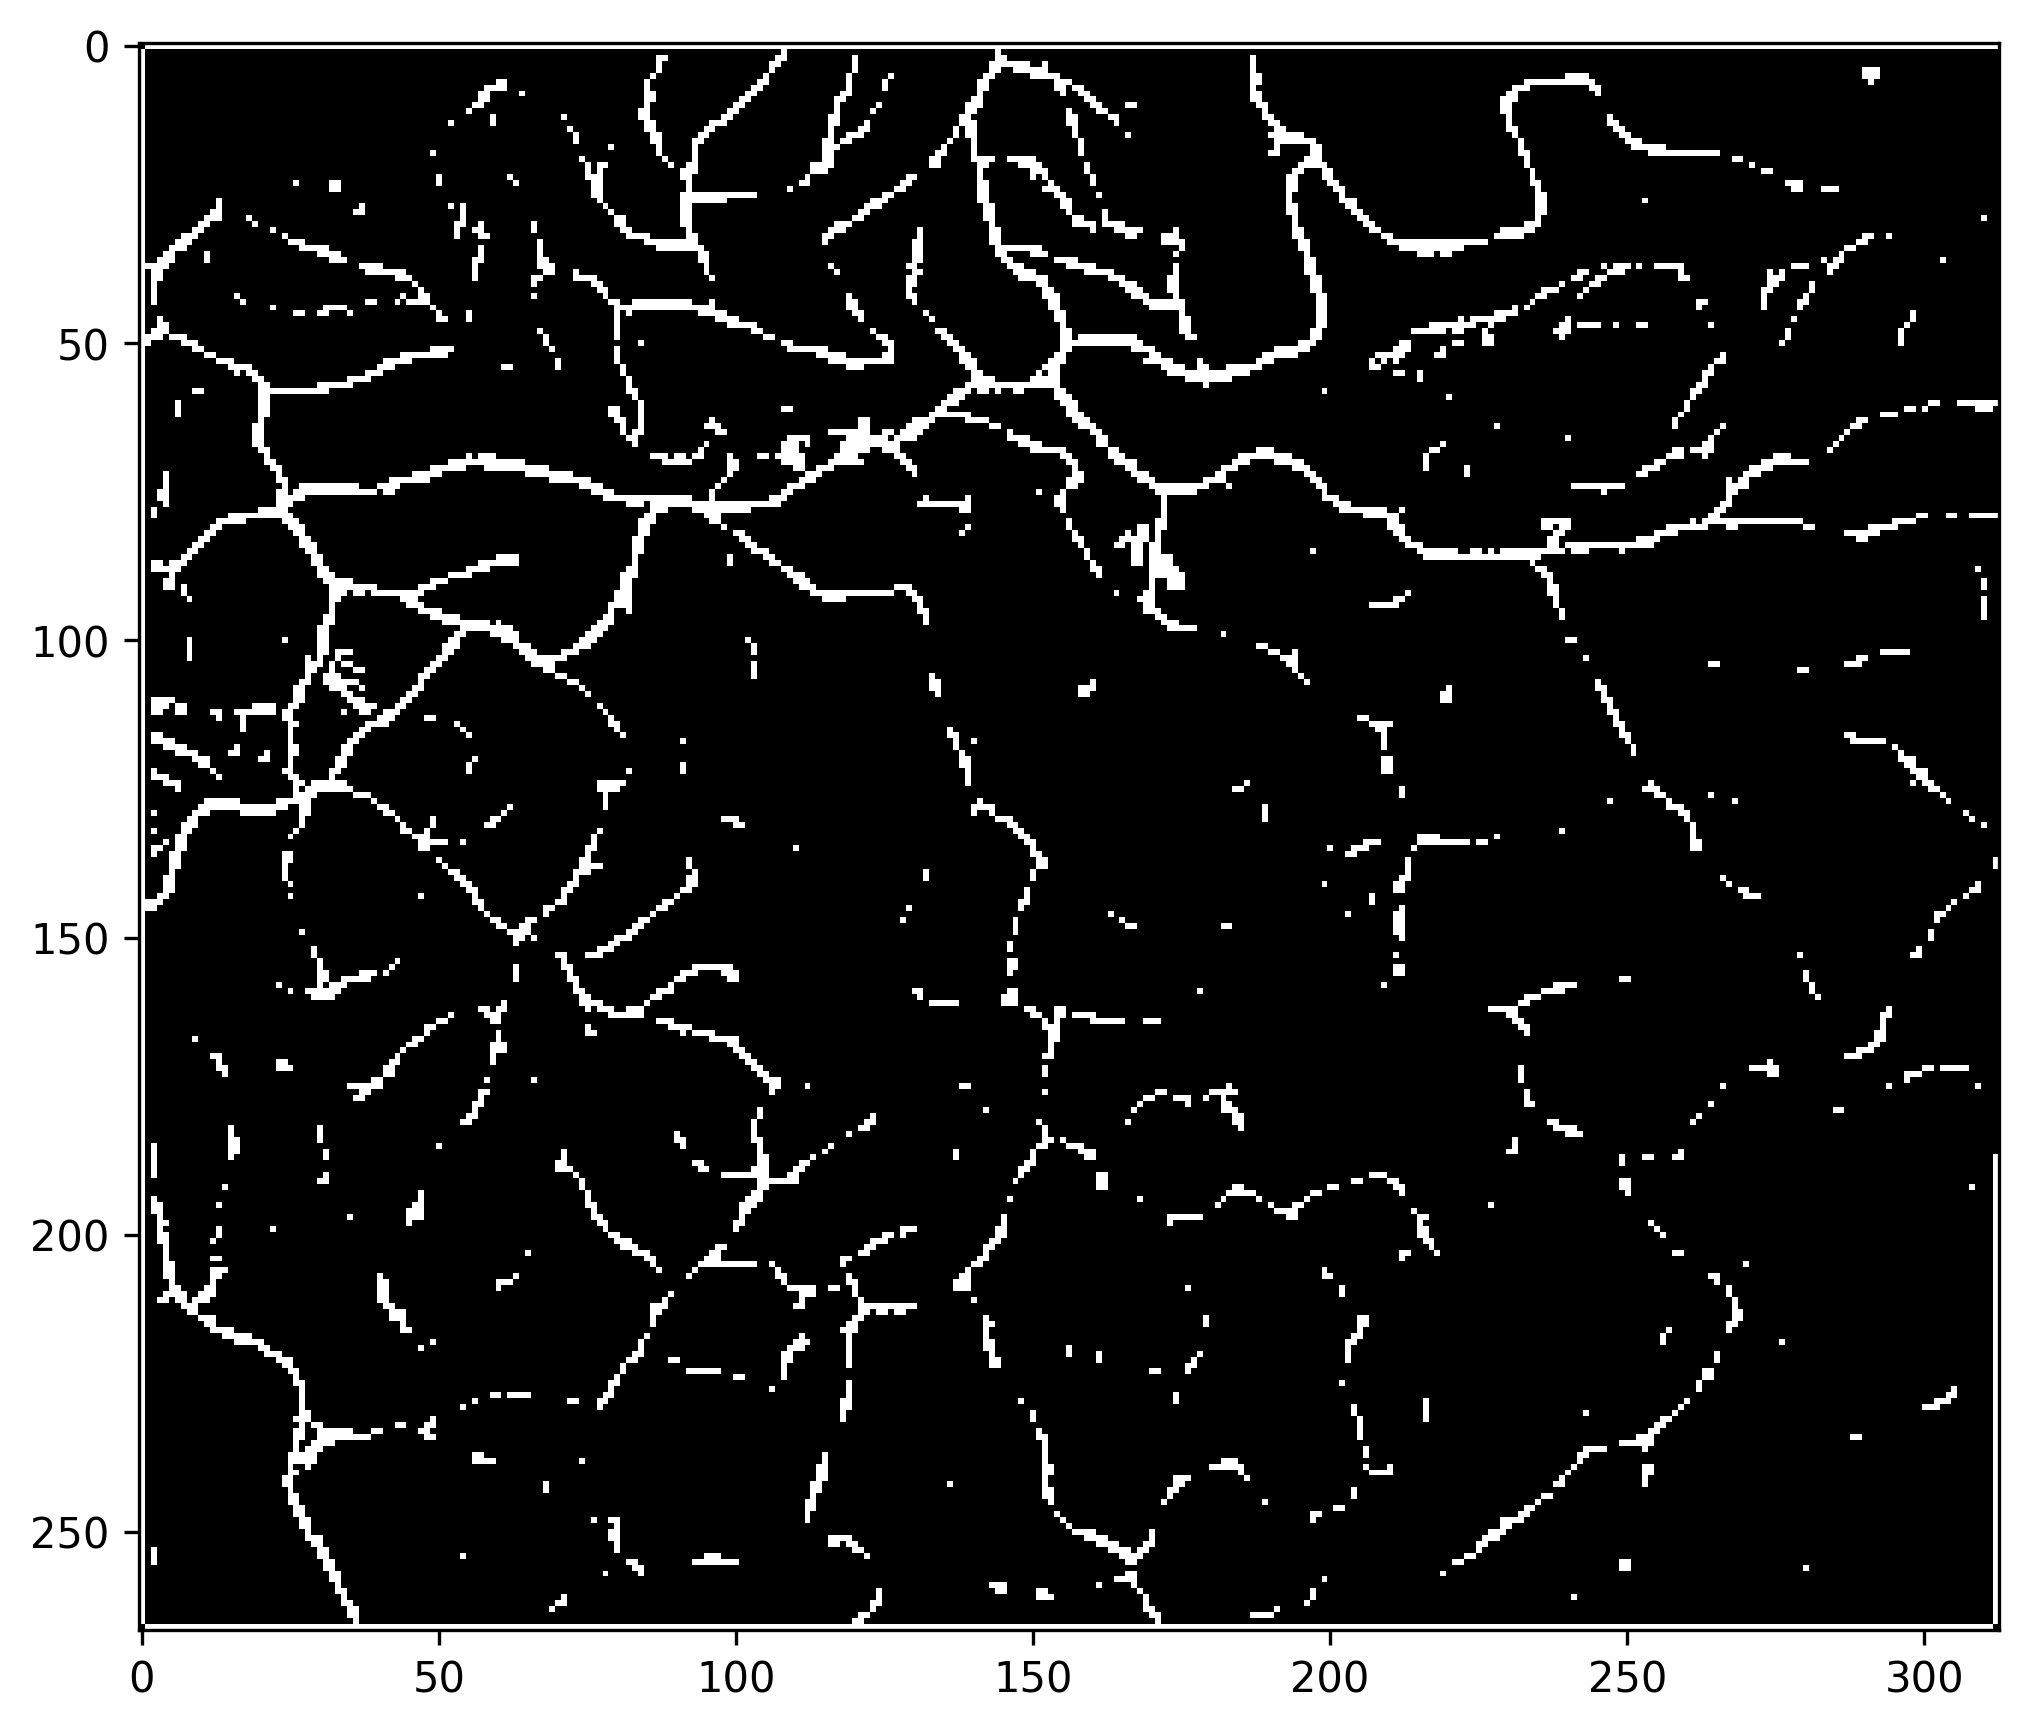

In [ ]:
# ラプラシアンフィルタの結果とマスクの論理積演算
nvdi_image_lap_masked = cv2.bitwise_and(nvdi_image_lap, nvdi_image_mask)
# 得られた結果を強調
nvdi_image_lap_masked = cv2.inRange(nvdi_image_lap_masked, 30, 255)

# 結果の表示
plt.figure(figsize=(8,8))
plt.imshow(nvdi_image_lap_masked, cmap="gray");

> さらにエッジを膨張させます。

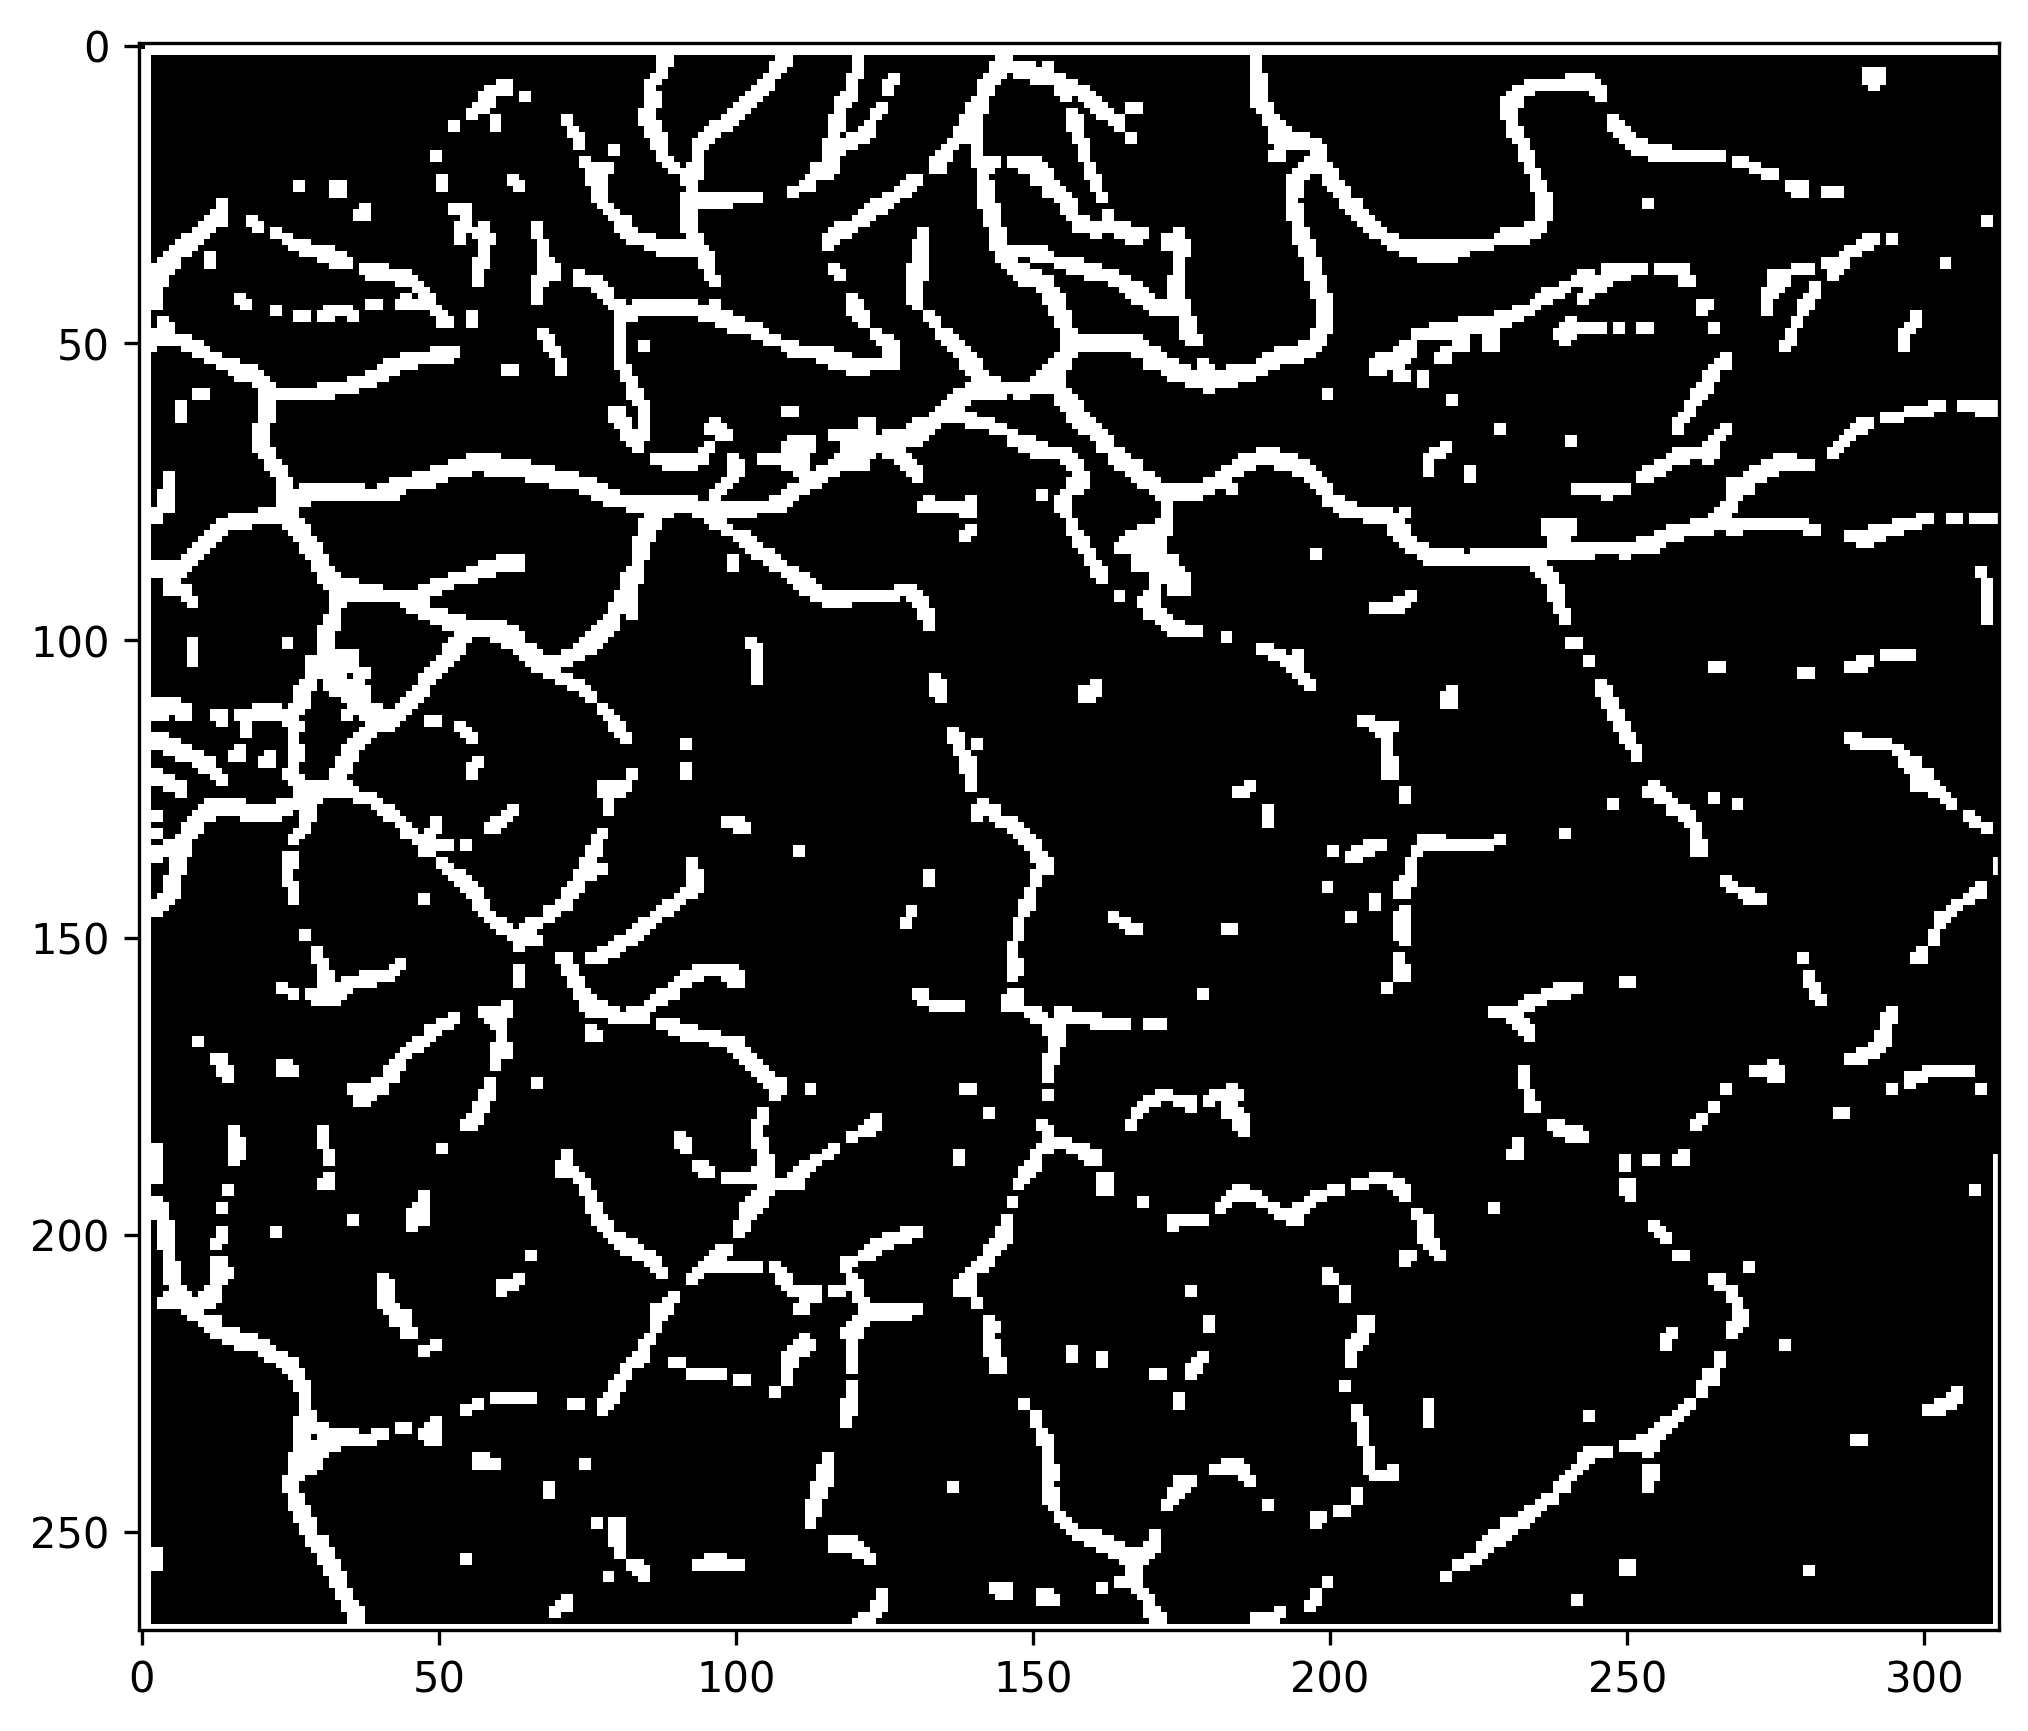

In [ ]:
# エッジを膨張させる
kernel = np.ones((2, 2)) / 8.0
nvdi_image_lap_masked2 = cv2.dilate(nvdi_image_lap_masked, kernel)

# 膨張させたエッジの画像を表示
plt.figure(figsize=(8,8))
plt.imshow(nvdi_image_lap_masked2, cmap="gray");

> 最後にCanny法で得られた結果と重ね合わせて表示してみましょう。

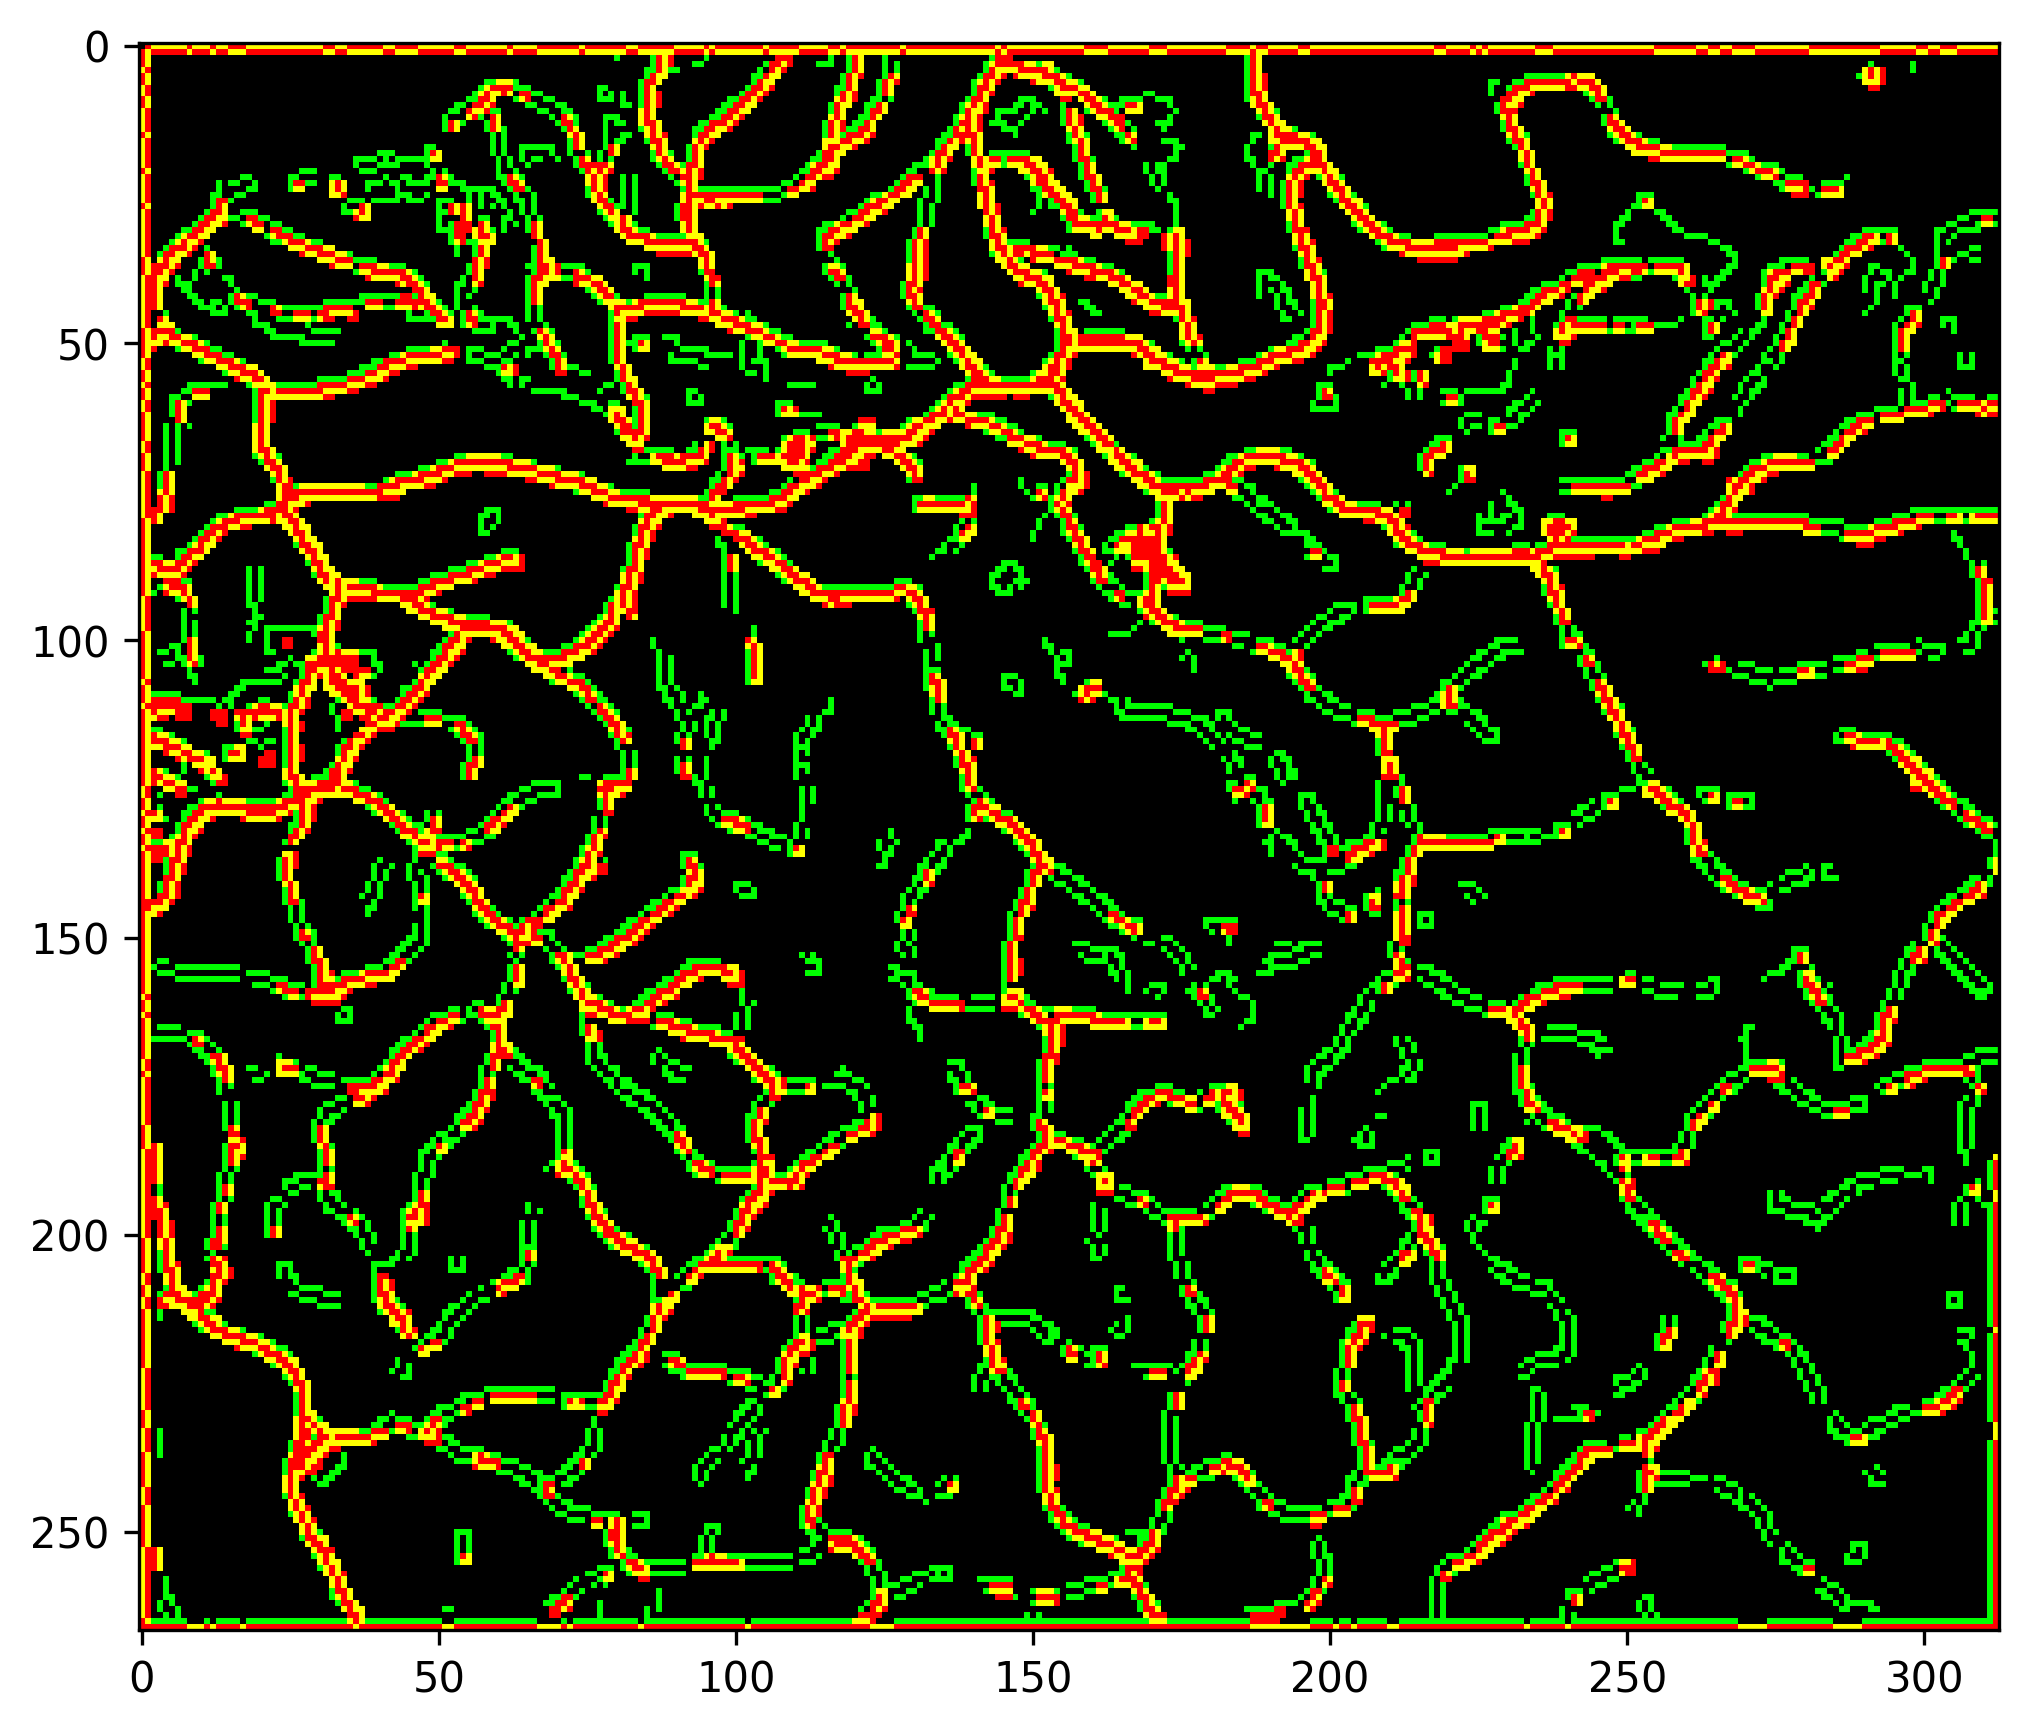

In [ ]:
nvdi_image_final = np.zeros((ca_image_nvdi.height, ca_image_nvdi.width, 3), dtype=np.uint8)

# Canny法は緑、ラプラシアンフィルタは赤で描画（重なっているところは黄色で表示される）
nvdi_image_final[:, :, 1] = nvdi_edged_canny
nvdi_image_final[:, :, 2] = nvdi_image_lap_masked2

# 重ね合わせた画像を表示する
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(nvdi_image_final, cv2.COLOR_BGR2RGB));

> プランテーション農園において縦横無尽に伸びる道路へ色をつけて強調できました。このようにOpenCVの画像処理関数やフィルタを組み合わせることで、画像から多くの情報を得ることができます。  
この演習では特定の日時のNVDIを表示しただけですが、たとえば季節変動で植生がどの程度変化するなど、異なる日時の画像で比較すると、植物の生育に影響を与える複数の事象を確認できることでしょう。